# Overview 
This code is designed to impot various models made by the Meudon PDR Code with eery time only one parameter changed in order to follow and study the impact of every single parameter during the update of CO. 

This update is made on the same model Orion Bar like with $G_0 = 10,280$ and $P_{th}= 5.2\times 10^7 K cm^{-3}$. When the differences are aknoledged on this model, we will run a model grid to see if the differences remain the same thoughought the parameter space. 

# Process 

Starting from CO computed with 64 levels, we tend to update the number of levels considered (going to 320), the radiative transfer in X, the collision with H, then with H2, and implement the UV transfer through the addition of UV cascade from A level to X level, and trating the higher electronic predissociating levels in full transfer. 

## 0. Libraries importation and definition of functions 

In [10]:
#1] Library importation 

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from typing import Optional, List
import plotly.io as pio
pio.renderers.default = 'iframe'

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


#Custom library 
import sys
chemin_modules = "/Users/aurelien/Desktop/PhD/Codes/Package/Perso/"
sys.path.append(chemin_modules)
import viz as viz 
import to_PDR
import read 
viz.Setting_Figure("Excitation")

#Setup of generic variables
path = "/Users/aurelien/Desktop/PhD/PDR/PDR7/AnalysisTools/IDAT/"
output = path +"co_Nu.txt"

def create_Nu_Idat(df, output_filename="co_Nu.txt", molecule_name="CO"):
    """
    Crée un fichier texte où chaque ligne représente une notation moléculaire
    N(Molecule v=V,J=J) basée sur les colonnes 'v' et 'J' d'un DataFrame.

    Args:
        df (pd.DataFrame): Le DataFrame contenant les colonnes 'v' et 'J'.
        output_filename (str): Le nom du fichier texte à créer.
        molecule_name (str): Le nom de la molécule à utiliser dans la notation (ex: "CO", "H2O").
                              Par défaut à "CO".
    """
    if 'v' not in df.columns or 'J' not in df.columns:
        raise ValueError("Le DataFrame doit contenir les colonnes 'v' et 'J'.")

    with open(output_filename, 'w') as f:
        for index, row in df.iterrows():
            v_val = row['v']
            J_val = row['J']

            if pd.isna(v_val) or pd.isna(J_val):
                print(f"Attention: Ligne {index} ignorée en raison de valeurs v/J manquantes: v={v_val}, J={J_val}")
                continue 

            line_to_write = f"N({molecule_name} v={int(v_val)},J={int(J_val)})"
            f.write(line_to_write + '\n')

    print(f"Fichier '{output_filename}' créé avec succès.")

def df_to_excitation_plotly(
    df: pd.DataFrame,
    x_col: str = 'En(K)',
    y_col: str = 'Norm',
    color_col: str = 'v',
    molecule_name: str = 'CO',
    v_levels_to_plot: Optional[List[int]] = None,
    cmap: str = "viridis",
    log_y: bool = True
) -> go.Figure:
    
    required_cols = [x_col, y_col, color_col, 'n', 'v', 'J']
    if not all(col in df.columns for col in required_cols):
        missing_cols = [col for col in required_cols if col not in df.columns]
        raise ValueError(f"Le DataFrame ne contient pas les colonnes nécessaires : {missing_cols}")
        
    df_plot = df.copy()

    if v_levels_to_plot is not None:
        df_plot = df_plot[df_plot[color_col].isin(v_levels_to_plot)].copy() 
        if df_plot.empty:
            print(f"Avertissement : Aucun point trouvé pour les niveaux spécifiés : {v_levels_to_plot}.")
            return px.scatter(title="Figure Vide")
            
    custom_data_cols = ['n', 'v', 'J'] 
    fig = px.scatter(
        df_plot, 
        x=x_col,
        y=y_col,
        color=color_col,
        log_y=log_y,
        color_continuous_scale=cmap,
        labels={
            x_col: r'Upper level energy E<sub>u</sub> [K]',
            y_col: r'Normalised column density N<sub>u</sub>/g<sub>u</sub> [cm<sup>-2</sup>]',
            color_col: 'Vibrational level v<sub>u</sub>'
        },
        title=f"Diagramme de Population Rotationnel pour {molecule_name}",
    )

    custom_template = (
        f"Upper level energy E<sub>u</sub> [K]=%{{x:.3f}}<br>"
        f"Normalised column density N<sub>u</sub>/g<sub>u</sub> [cm²]=%{{y:.5f}}<br>"
        f"Vibrational level v<sub>u</sub>=%{{customdata[1]}}<br>" # v (index 1)
        f"n=%{{customdata[0]}}<br>" # n (index 0)
        f"J=%{{customdata[2]}}<extra></extra>" # J (index 2)
    )
    
    fig.update_traces(
        marker=dict(size=10, opacity=0.8),
        customdata=df_plot[custom_data_cols], 
        hovertemplate=custom_template
    )
    
    return fig









def import_model_to_df (idat_name,df_level=df_level_co) : 
    Nu_Model = read.read_IDAT_Nu(path+idat_name)
    df_Model = pd.merge(df_level_co,Nu_Model,on=["v","J"])
    df_Model["Norm"]=df_Model["value"]/df_Model["g"]
    return df_Model





def plot_comparative_excitation(
    data1: pd.DataFrame,
    data2: pd.DataFrame,
    label1: str,
    label2: str,
    v_levels_to_plot: list,
    x_col: str = 'En(K)',
    y_col: str = 'Norm',
    color_col: str = 'v',
    molecule_name: str = 'co',
    figsize: tuple = (21, 12)
    ):
    """
    Crée un graphique comparatif en deux sous-panneaux (subplots) pour deux DataFrames.

    Le panneau supérieur montre le diagramme d'excitation superposé (data1 vs data2).
    Le panneau inférieur montre l'erreur relative entre data1 et data2.

    Args:
        data1 (pd.DataFrame): Premier DataFrame (utilisé comme référence pour l'erreur relative).
        data2 (pd.DataFrame): Deuxième DataFrame (comparé à data1).
        label1 (str): Nom de la première courbe (ex: 'MeudonPDR').
        label2 (str): Nom de la deuxième courbe (ex: 'HITRAN Update').
        v_levels_to_plot (list): Liste des niveaux vibrationnels 'v' à inclure.
        x_col (str): Nom de la colonne pour l'axe X (énergie).
        y_col (str): Nom de la colonne pour l'axe Y (valeur normalisée, ex: 'Norm').
        color_col (str): Nom de la colonne utilisée pour le code couleur (souvent 'v').
        molecule_name (str): Nom de la molécule pour les titres et légendes.
        figsize (tuple): Taille de la figure Matplotlib.
    """

    fig, (ax1, ax2) = plt.subplots(
        2, 1, 
        figsize=figsize, 
        sharex=True, 
        gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.01}
    )
    
    viz.df_to_excitation_pyplot(
        data1,
        v_levels_to_plot=v_levels_to_plot,
        x_col=x_col,
        y_col=y_col,
        color_col=color_col,
        molecule_name=f"{molecule_name}_{label1}",
        ax_target=ax1,
        cmap="coolwarm", markers="o", alpha=1, empty=None
    )

    viz.df_to_excitation_pyplot(
        data2,
        v_levels_to_plot=v_levels_to_plot,
        x_col=x_col,
        y_col=y_col,
        color_col=color_col,
        molecule_name=f"{molecule_name}_{label2}",
        ax_target=ax1,
        cmap="coolwarm_r", markers="o", alpha=0.5, empty=False
    )
    
    ax1.set_xlabel('') 
    ax1.set_ylabel(r'Column density $N/g$ (Log)', fontsize=25)
    ax1.grid(True, which="both", ls="-", alpha=0.6)
    ax1.set_yscale('log')
    ax1.legend(loc="best", fontsize=20, ncol=2)
    
    df1_filtered = data1[data1[color_col].isin(v_levels_to_plot)]
    df2_filtered = data2[data2[color_col].isin(v_levels_to_plot)]
    
    df_merged_err = pd.merge(
        df1_filtered[[x_col, y_col, color_col]], 
        df2_filtered[[x_col, y_col, color_col]], 
        on=[x_col, color_col], 
        suffixes=('_1', '_2')
    ).dropna(subset=[f'{y_col}_1', f'{y_col}_2'])
    
    relative_err = np.abs(df_merged_err[f'{y_col}_1'] - df_merged_err[f'{y_col}_2']) / df_merged_err[f'{y_col}_1'] * 100
    
    ax2.plot(
        df_merged_err[x_col], 
        relative_err, 
        marker='.', 
        linestyle='--', 
        label=r'Rate of Change $\left(\frac{|N_1/g - N_2/g|}{N_1/g}\right) \times 100$', 
        color='black'
    )

    ax2.axhline(10, color='green', linestyle='-', linewidth=1, label=r"10$\%$")
    ax2.axhline(100, color='red', linestyle='-', linewidth=1, label=r"100$\%$")

    ax2.set_xlabel(f'{x_col}', fontsize=25)
    ax2.set_ylabel(r' Erreur Relative [$\%$]', fontsize=20)
    ax2.set_ylim(-5, np.max([relative_err.max() * 1.1, 110])) 
    ax2.grid(True, which="both", ls="-", alpha=0.6)
    ax2.legend(fontsize=15)
    
    plt.tight_layout()
    plt.show()

## 1. Importation of all files
Every model is stored in a dataframe of the pandas library in order to easily navigate through the data and add easily columns to the method

In [37]:
#
df_level_co = to_PDR.Level_to_pd("co")
#create_Nu_Idat(df_level_co,output)

# Importation of the different models 
Model_NameList = ["Orion_Base64.txt","Model5_Base320.txt","Orion_Base64_UV.txt","Orion_All64.txt","Orion_All64_UV.txt",
                  "Model5_Hi320.txt","coll_co_h_320_G1e4.dat",'Orion_CollHH2_V6.dat' ,
                  "Orion_BestFit_Hit_Coll_UV_idat.dat","Orion_Base320_UV_idat.dat","Orion_All320_Exact.dat"]

Model_Surname = ["Base64", "Base320", "Base64_UV", "All64","All64_UV",
                 "Hitran320","Coll_H_320","Coll_H2_320",
                 "All320_UV","Base320_UV","All320_UV_Exact"]
Model ={} #Dictionary of the models 

for file_name, surname in zip(Model_NameList, Model_Surname):
    df_Model = import_model_to_df(file_name)
    Model[surname] = df_Model


['n', 'g', 'En(K)', 'o', 'v', 'J', 'comment']


## 2. Presentation of the different graphical tools available
We present easy cases of comparisons between two models on an excitation diagram either by level v, or fully, with or without the + rate of change


### Simple figure for one model 


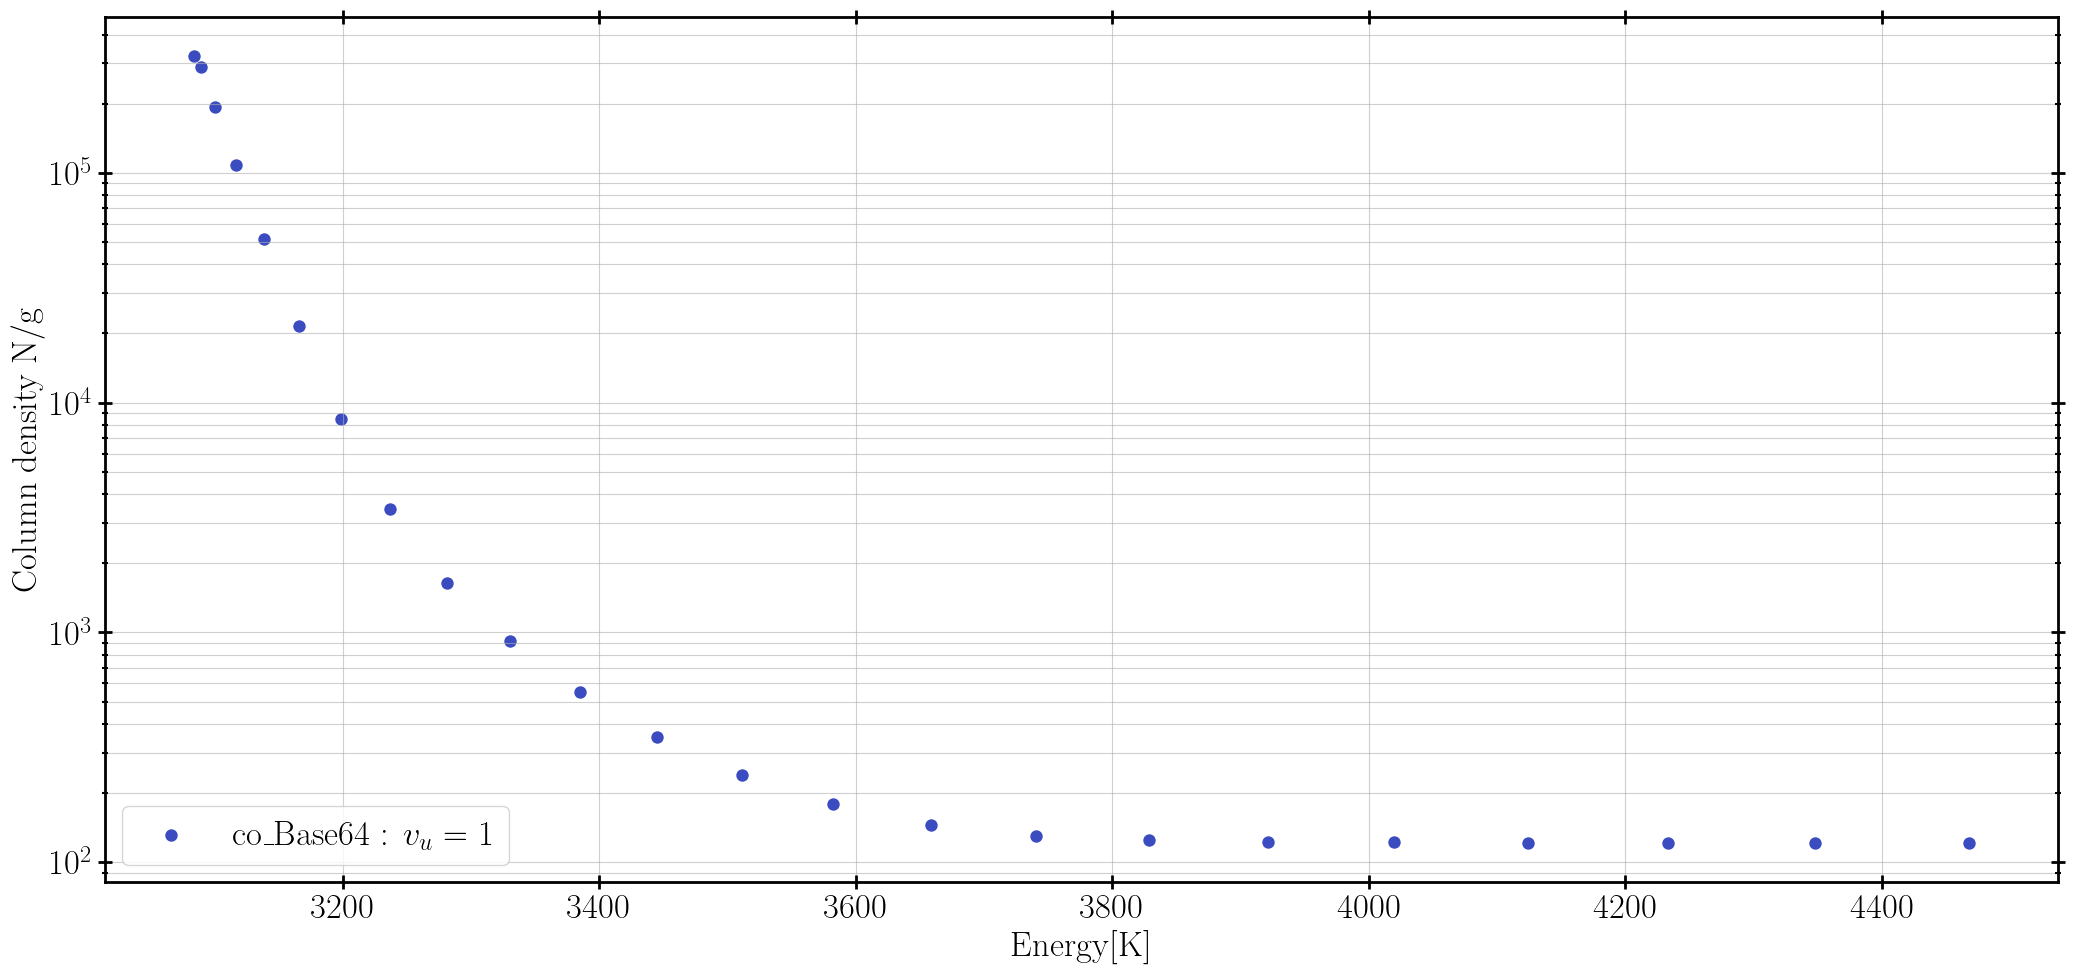

In [24]:
# Simple figure for one model 
#Selection of one or multiple levels to plot
v_levels = [1]
ModelName = "Base64"

fig, ax1 = plt.subplots(1, 1, figsize=(21, 10))

mol = "co"
ax = viz.df_to_excitation_pyplot(Model[ModelName], v_levels_to_plot=v_levels, #can be commented for full view
                                 x_col='En(K)', 
                                 y_col='Norm', 
                                 color_col='v', 
                                 molecule_name=f"{mol}_{ModelName}",
                                 ax_target=ax1,
                                 cmap="coolwarm",markers="o",alpha=1,empty=None)
ax1.set_xlabel('Energy[K]',fontsize=25)
ax1.set_ylabel(r'Column density N/g',fontsize=25)
ax1.grid(True, which="both", ls="-", alpha=0.6)
ax1.set_yscale('log') 
ax1.legend(loc="lower left",fontsize=25)
plt.tight_layout()  

### Interactive plot using plotly


In [25]:
#Selection of one or multiple levels to plot
v_levels = [1]
ModelName = "Base64"

fig = df_to_excitation_plotly(
    df=Model[ModelName],
    x_col='En(K)',
    y_col='Norm',
    color_col='v',
    molecule_name=f"{mol}_{ModelName}",
    v_levels_to_plot=v_levels,
    cmap="mint")
fig.show() 
#You have the detail of every level considered by passing the mouse on it 


### Comparative plot 

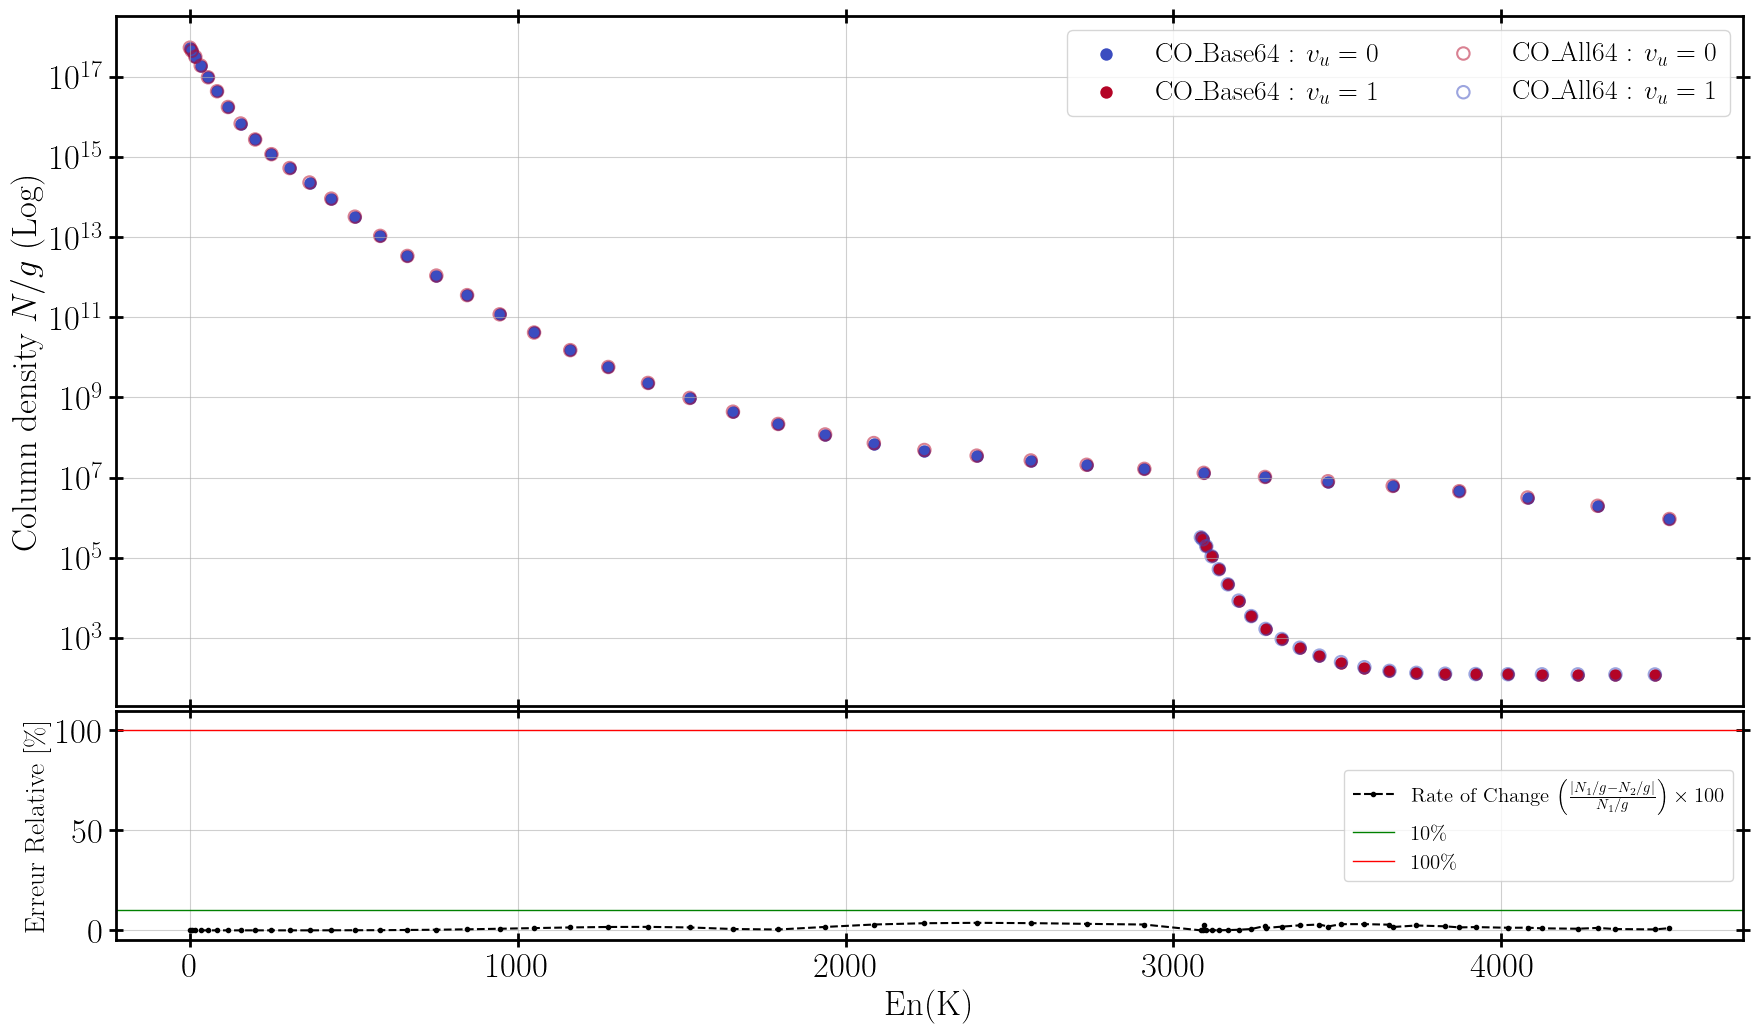

In [26]:
#Comparative plot : extitation diagram of 2 different models and % of rate of change between the 2

v_levels_to_plot = [0, 1]
label_1 = "Base64"
label_2 = "All64"

Model1 = Model[label_1]
Model2 = Model[label_2]

plot_comparative_excitation(data1=Model1,data2=Model2,
    label1=label_1,label2=label_2,
    v_levels_to_plot=v_levels_to_plot,
    x_col='En(K)', y_col='Norm',molecule_name='CO')

## 3. Updating process step by step 
The procedure is the folowwing : 
- Go from 64 levels to 320 levels
- Update radiative transfer in X ground based level changing Aij and dE
- Update collisions with H
- Update collision with H2 (ortho and para)
- Activate UV Cascade processing to take into account A->X Transitions
- Go from FGK transfer to Exact transfer for UV lines above A

### a. from 64 to 320 levels

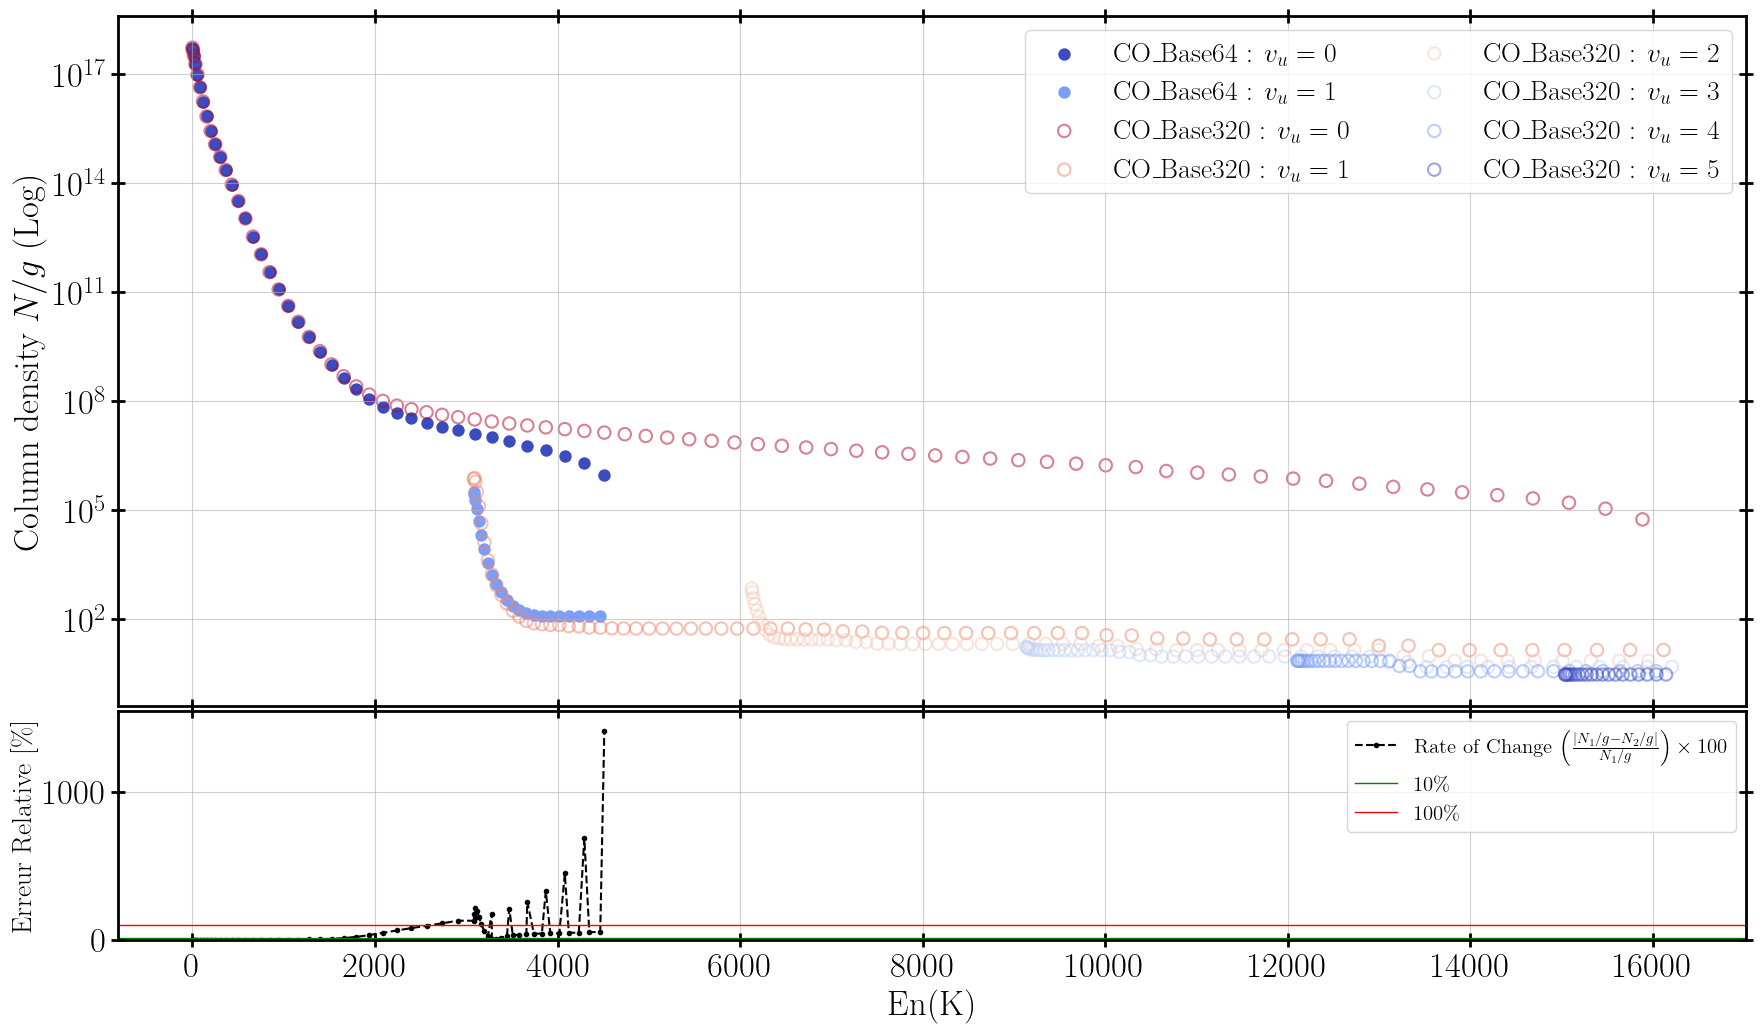

In [27]:
v_levels_to_plot = [0, 1,2,3,4,5]
label_1 = "Base64"
label_2 = "Base320"

Model1 = Model[label_1]
Model2 = Model[label_2]

plot_comparative_excitation(data1=Model1,data2=Model2,
    label1=label_1,label2=label_2,
    v_levels_to_plot=v_levels_to_plot,
    x_col='En(K)', y_col='Norm',molecule_name='CO')

#### Discussion 
We observe a difference in the high J at v=0 and for all J at v=1. 
- v=0 : the high J are more populated than before
- v=1 : the first levels are less populated, then more populated than previoulsy
Keep in mind that the physics are not implemented yet so the results may be unphysical

We observe a relative difference getting to 1000% at maximum. 
We also observe the v=2,3,4 are now partially popylated and follow the classical curve. 
The staircase appearance at high J is due to the lack of precision in collision rate values

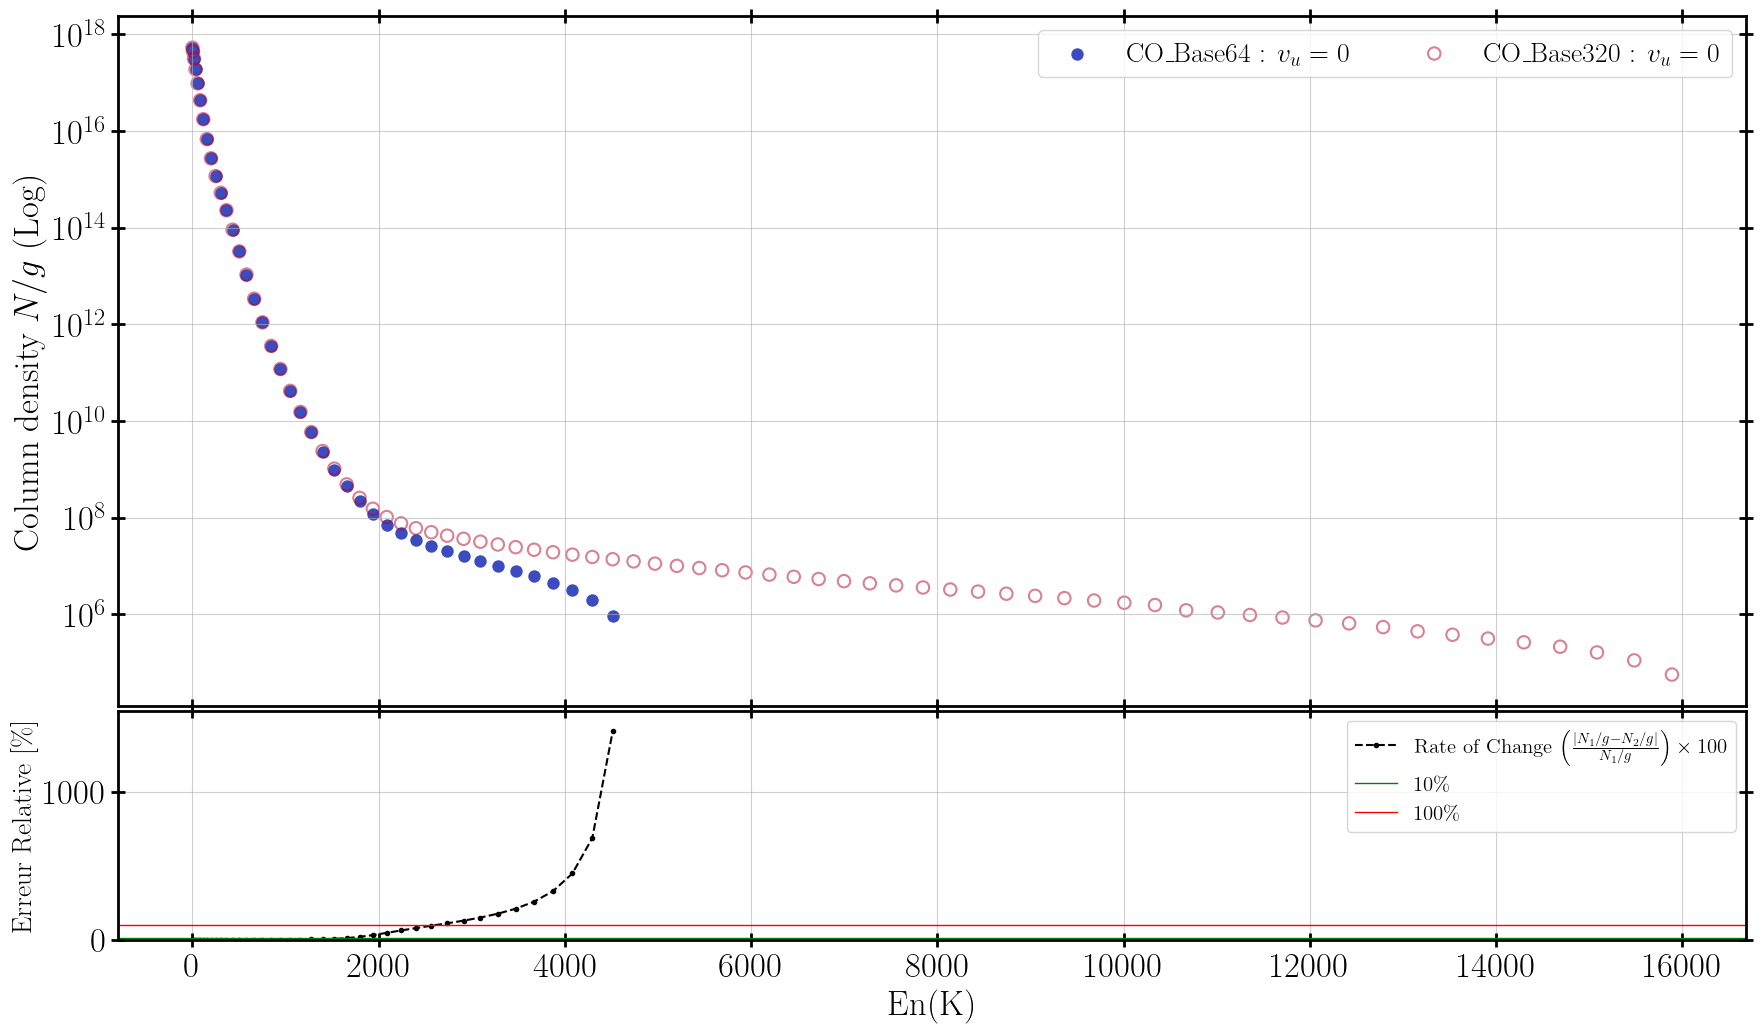

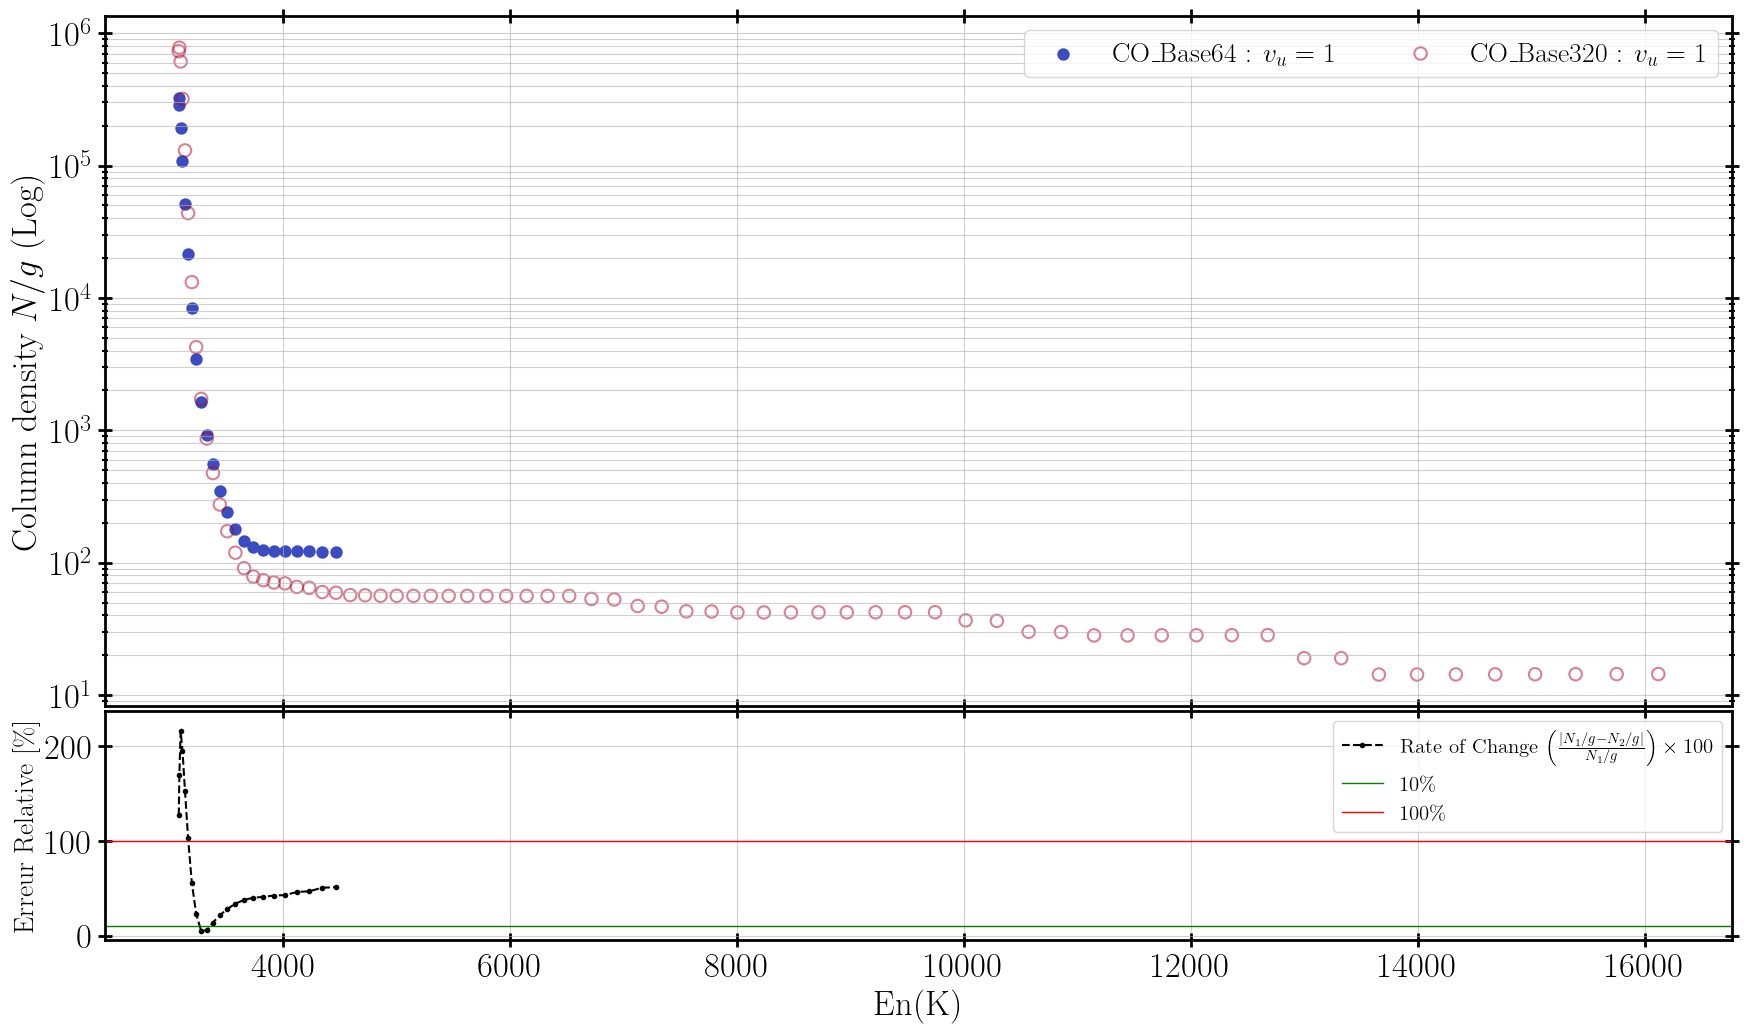

In [28]:
v_levels_to_plot = [0]
label_1 = "Base64"
label_2 = "Base320"

Model1 = Model[label_1]
Model2 = Model[label_2]

plot_comparative_excitation(data1=Model1,data2=Model2,
    label1=label_1,label2=label_2,
    v_levels_to_plot=v_levels_to_plot,
    x_col='En(K)', y_col='Norm',molecule_name='CO')


v_levels_to_plot = [1]
label_1 = "Base64"
label_2 = "Base320"

Model1 = Model[label_1]
Model2 = Model[label_2]

plot_comparative_excitation(data1=Model1,data2=Model2,
    label1=label_1,label2=label_2,
    v_levels_to_plot=v_levels_to_plot,
    x_col='En(K)', y_col='Norm',molecule_name='CO')

### b. Update of radiative coefficients in X

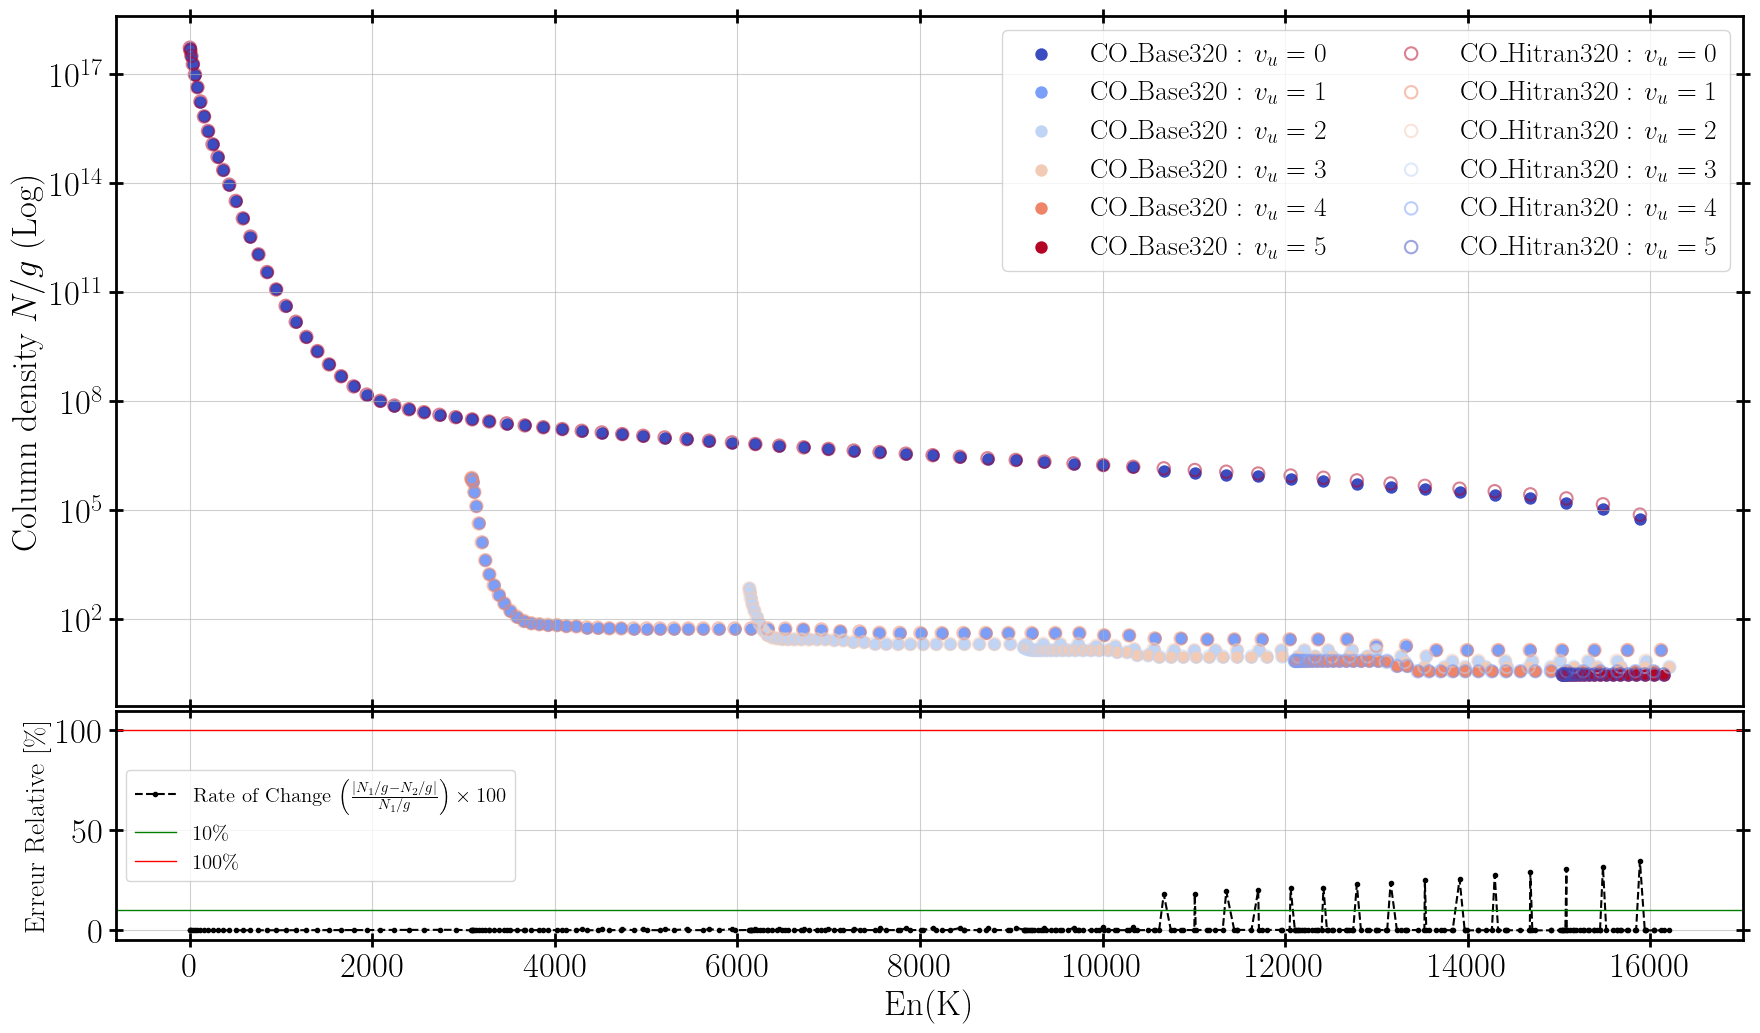

In [29]:
v_levels_to_plot = [0,1,2,3,4,5]
label_1 = "Base320"
label_2 = "Hitran320"

Model1 = Model[label_1]
Model2 = Model[label_2]

plot_comparative_excitation(data1=Model1,data2=Model2,
    label1=label_1,label2=label_2,
    v_levels_to_plot=v_levels_to_plot,
    x_col='En(K)', y_col='Norm',molecule_name='CO')

#### Observations 
We see that the update of radiative coefficients Aij and dE doesn't change much more than 20% maximum at v=0, high J (see next plot). 
Even if we observe a huge difference in Aij 4-0,4-4,5-1 and 5-5 in the initial data, those changes are orders of magnitude below the main processes populating those levels, so in results, only small changes of around 1% is visible in those levels

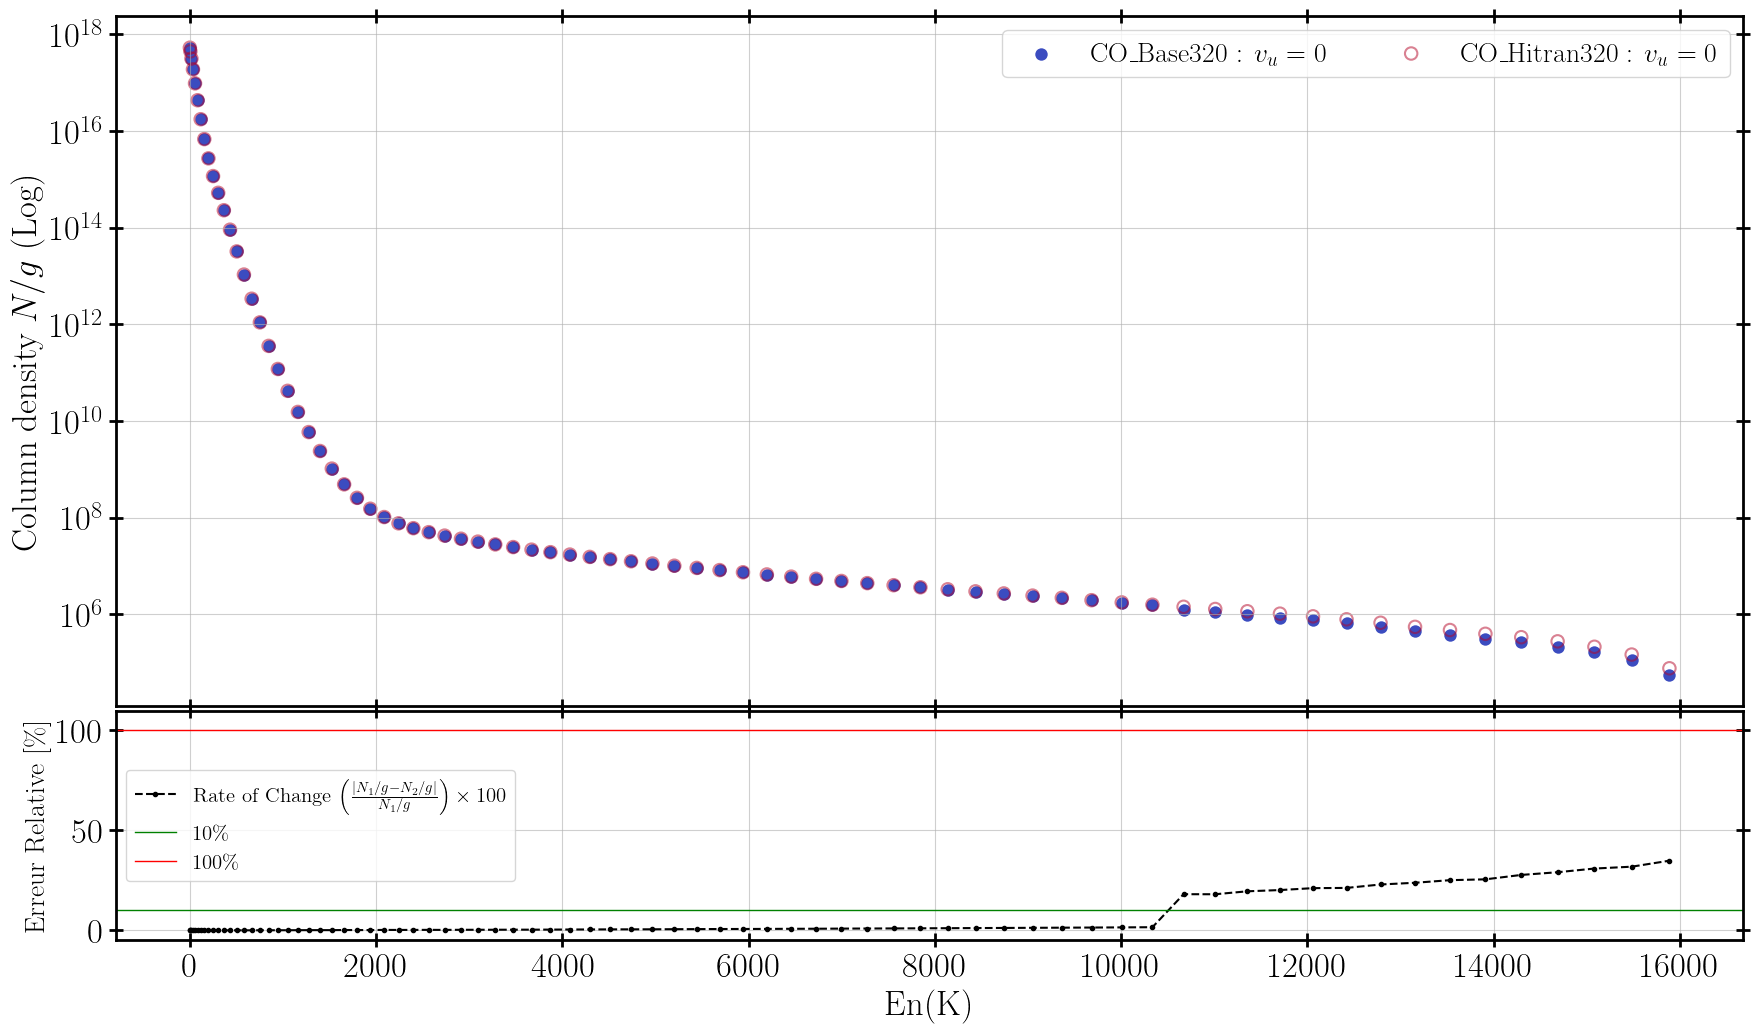

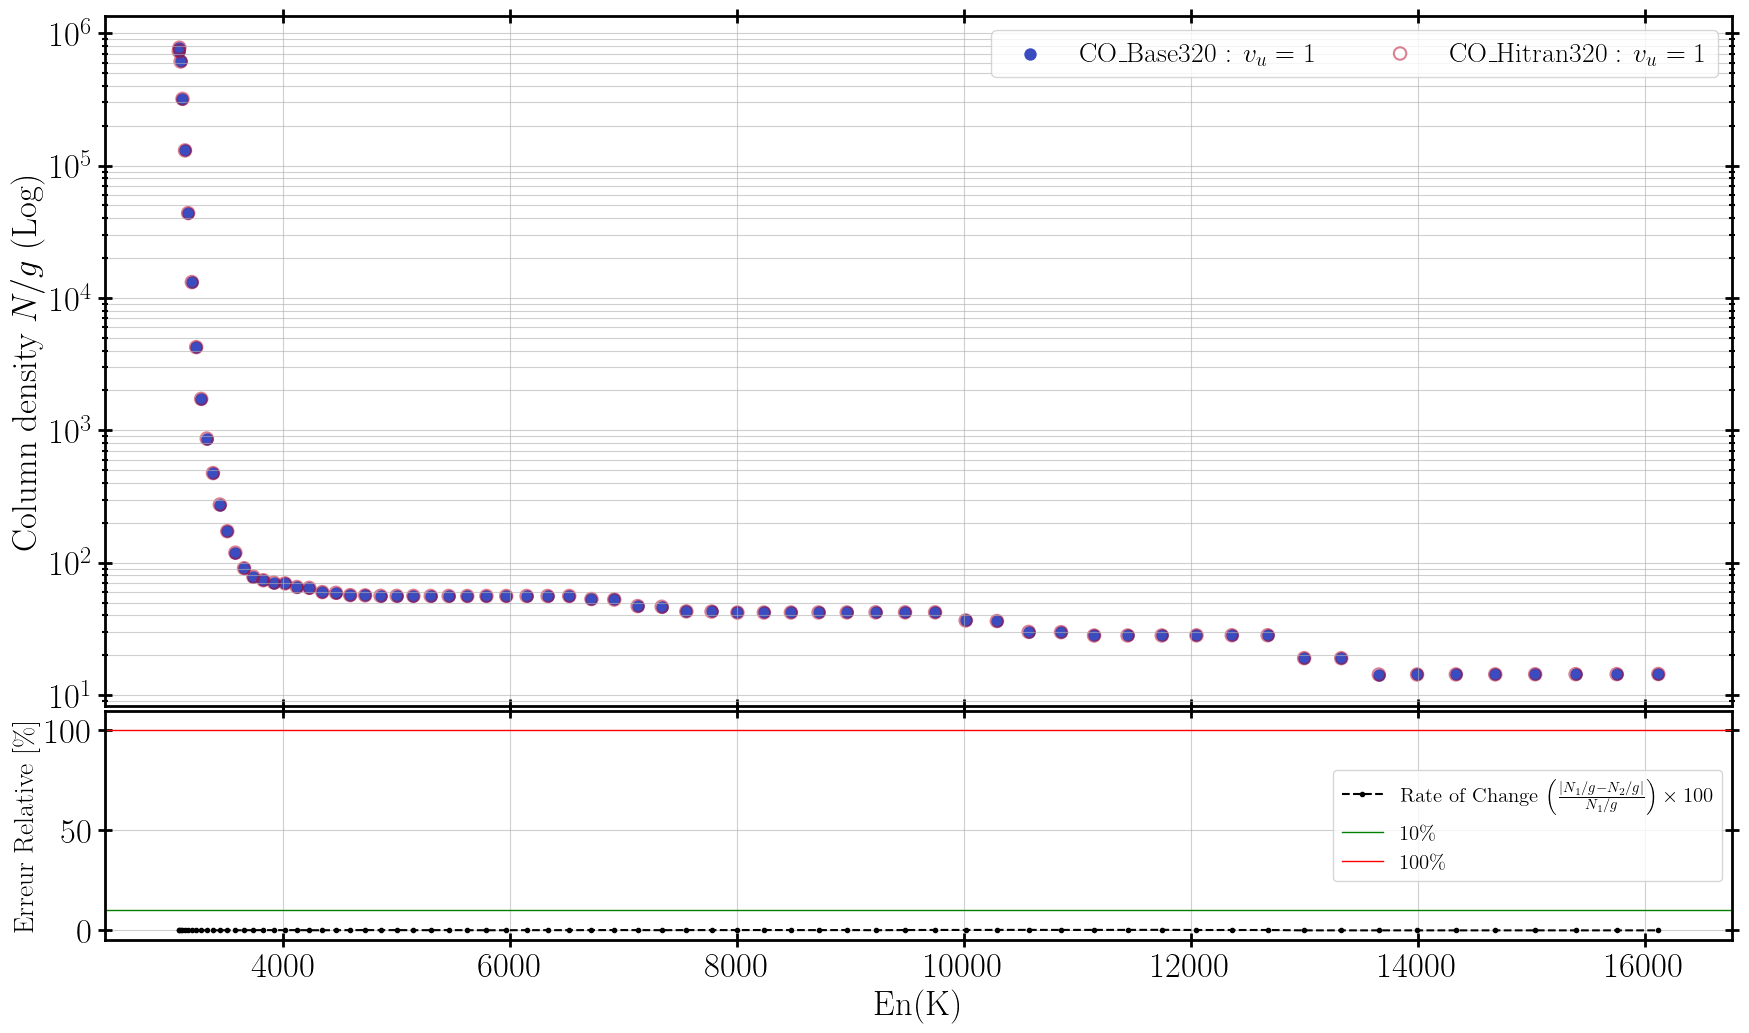

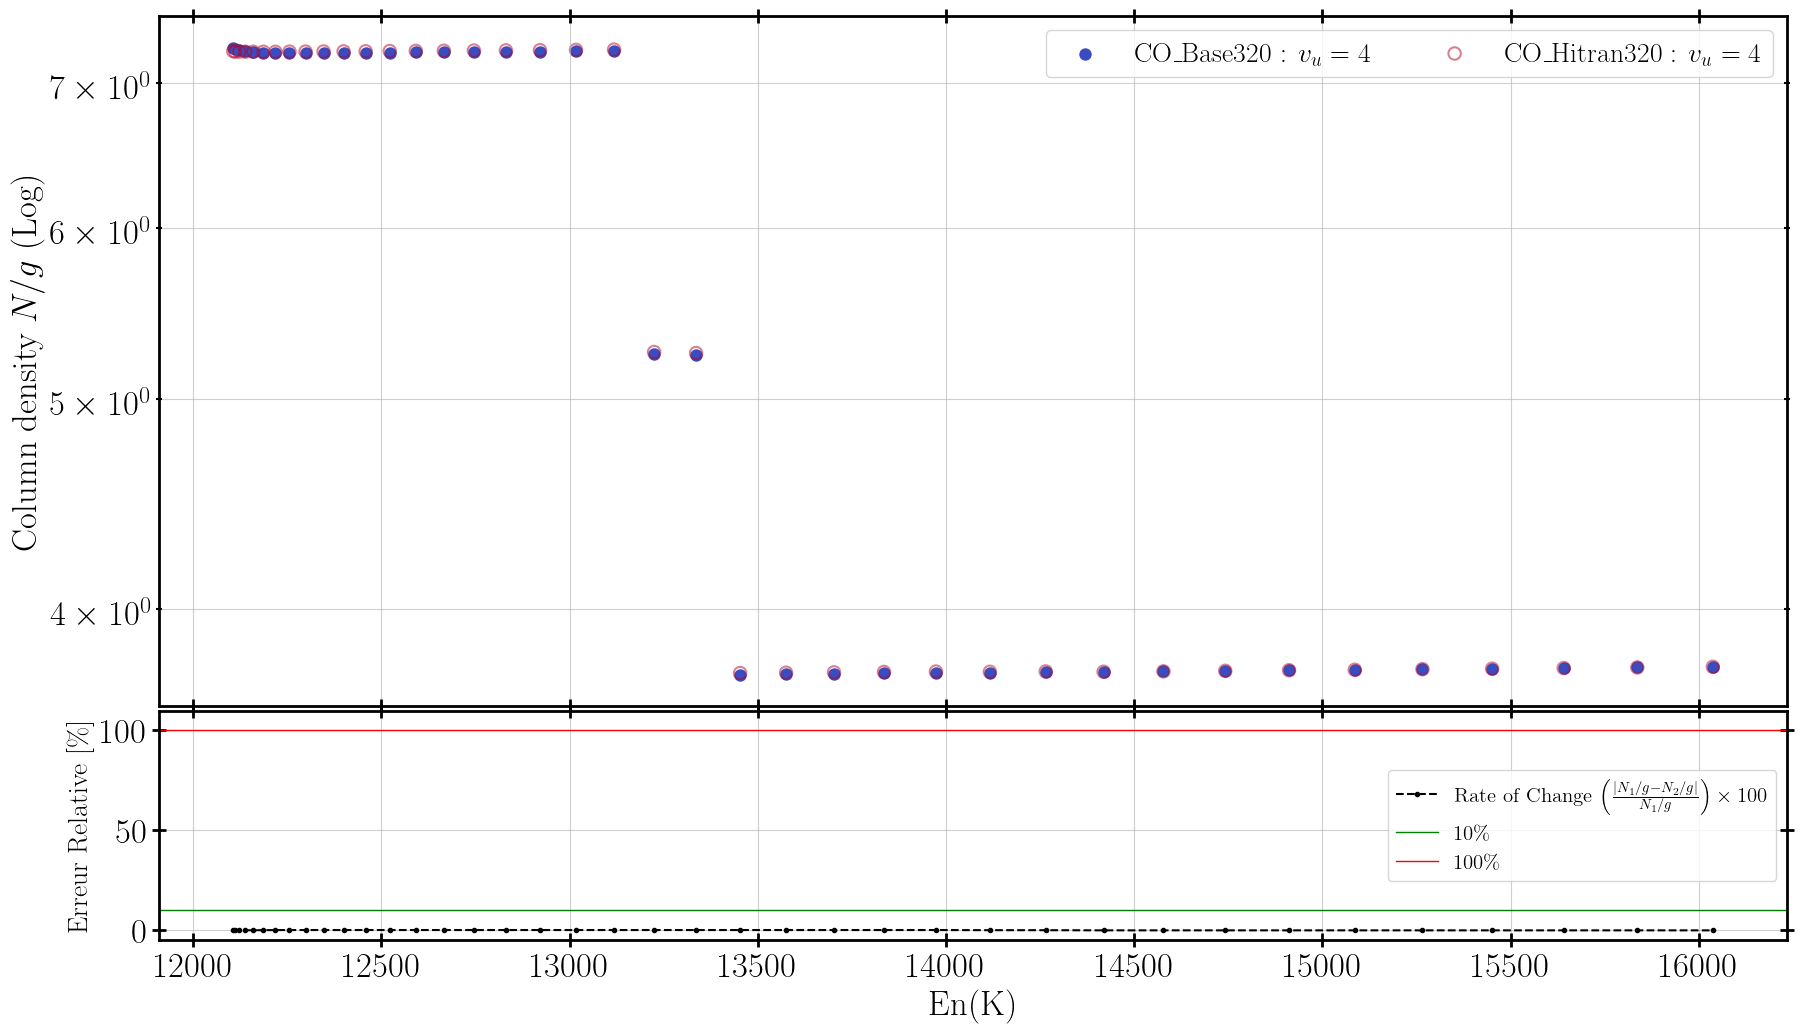

In [30]:
v_levels_to_plot = [0]
label_1 = "Base320"
label_2 = "Hitran320"

Model1 = Model[label_1]
Model2 = Model[label_2]

plot_comparative_excitation(data1=Model1,data2=Model2,
    label1=label_1,label2=label_2,
    v_levels_to_plot=v_levels_to_plot,
    x_col='En(K)', y_col='Norm',molecule_name='CO')


#-----------------------------------------------------------
v_levels_to_plot = [1]
label_1 = "Base320"
label_2 = "Hitran320"

Model1 = Model[label_1]
Model2 = Model[label_2]

plot_comparative_excitation(data1=Model1,data2=Model2,
    label1=label_1,label2=label_2,
    v_levels_to_plot=v_levels_to_plot,
    x_col='En(K)', y_col='Norm',molecule_name='CO')



#-----------------------------------------------------------
v_levels_to_plot = [4]
label_1 = "Base320"
label_2 = "Hitran320"

Model1 = Model[label_1]
Model2 = Model[label_2]

plot_comparative_excitation(data1=Model1,data2=Model2,
    label1=label_1,label2=label_2,
    v_levels_to_plot=v_levels_to_plot,
    x_col='En(K)', y_col='Norm',molecule_name='CO')


### c. Update of collision rates with H

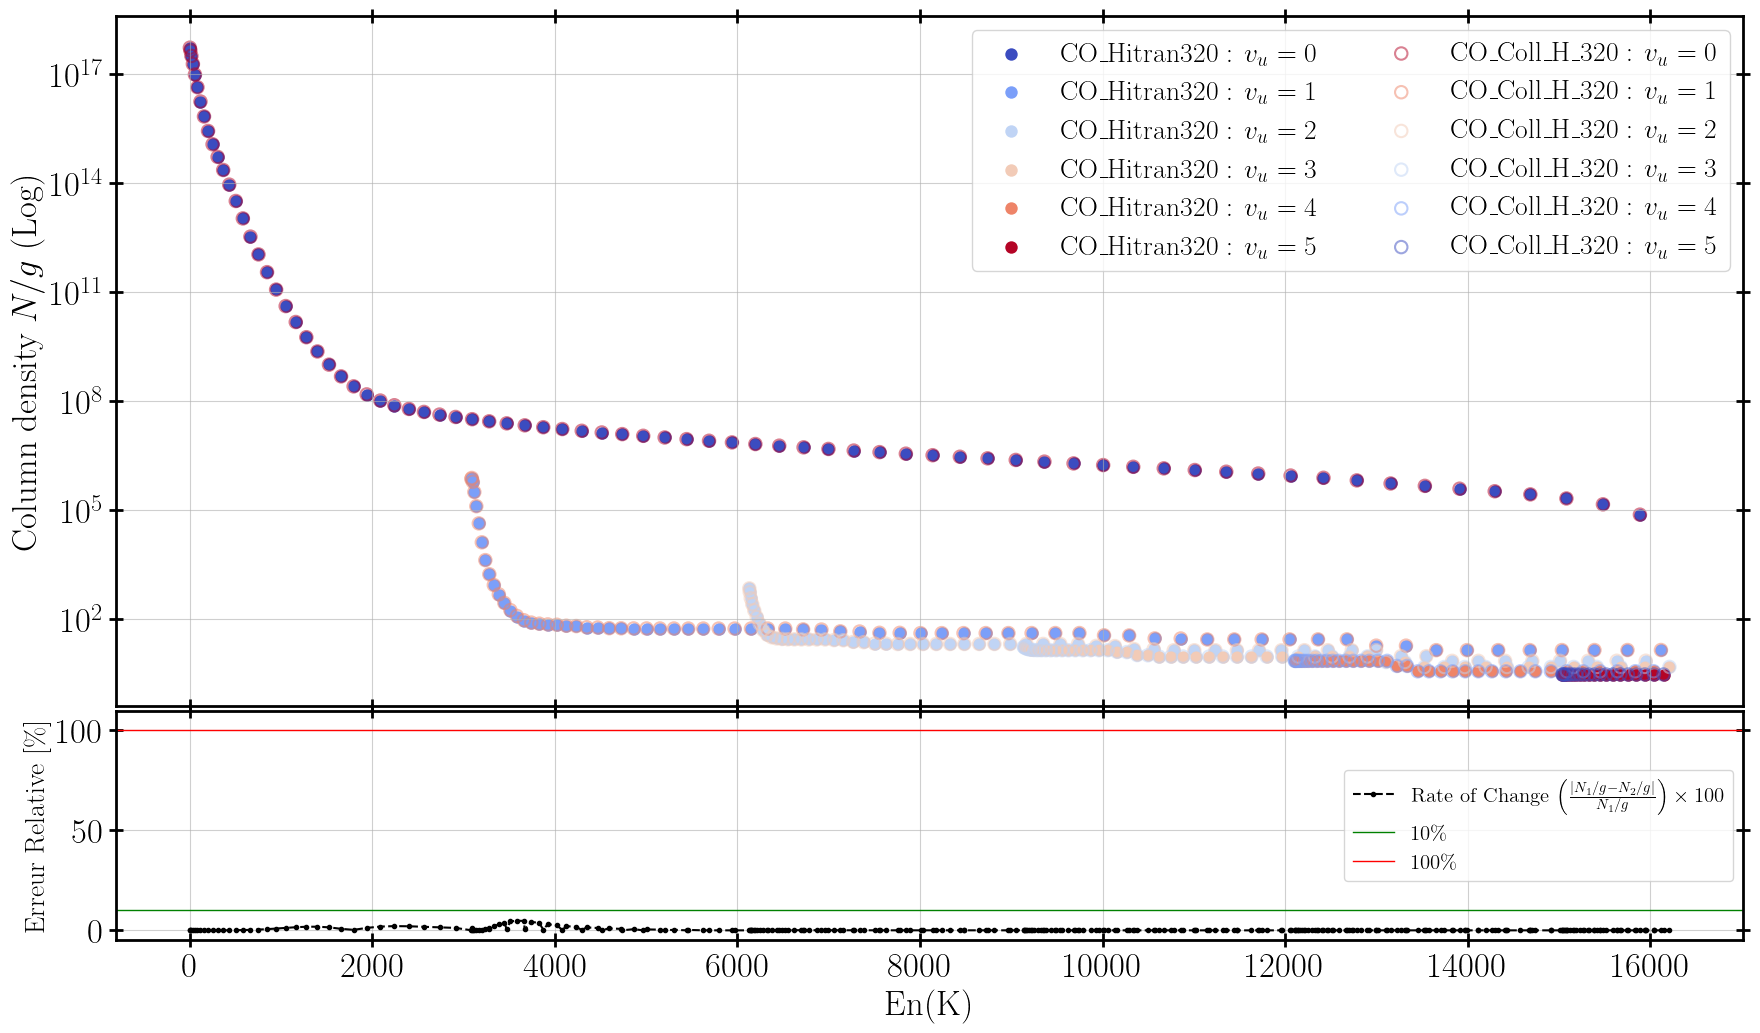

In [31]:
v_levels_to_plot = [0,1,2,3,4,5]
label_1 = "Hitran320"
label_2 = "Coll_H_320"

Model1 = Model[label_1]
Model2 = Model[label_2]

plot_comparative_excitation(data1=Model1,data2=Model2,
    label1=label_1,label2=label_2,
    v_levels_to_plot=v_levels_to_plot,
    x_col='En(K)', y_col='Norm',molecule_name='CO')

#### Observations 
The update of collision rates between CO and H doesn't change much in this model : only few % of difference mainly in v=1 (and a little bit in v=0) 

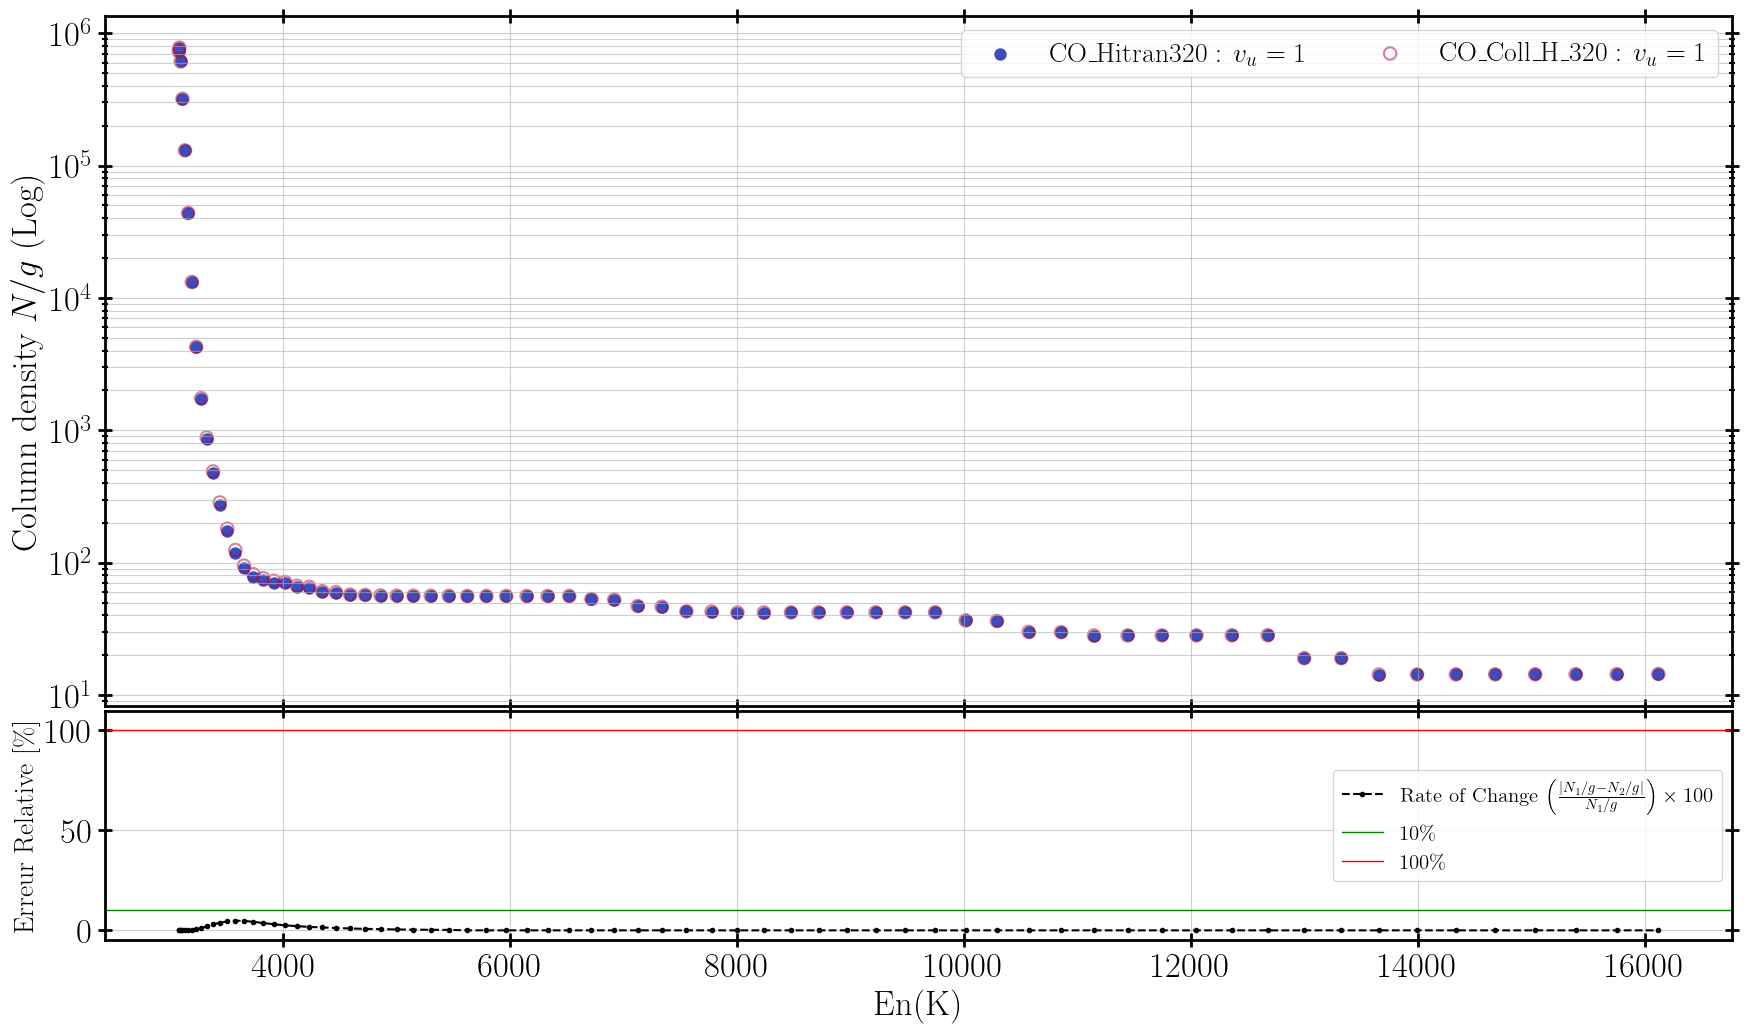

In [32]:
v_levels_to_plot = [1]
label_1 = "Hitran320"
label_2 = "Coll_H_320"

Model1 = Model[label_1]
Model2 = Model[label_2]

plot_comparative_excitation(data1=Model1,data2=Model2,
    label1=label_1,label2=label_2,
    v_levels_to_plot=v_levels_to_plot,
    x_col='En(K)', y_col='Norm',molecule_name='CO')

### d. Update of collision rates with H2 (ortho and para)

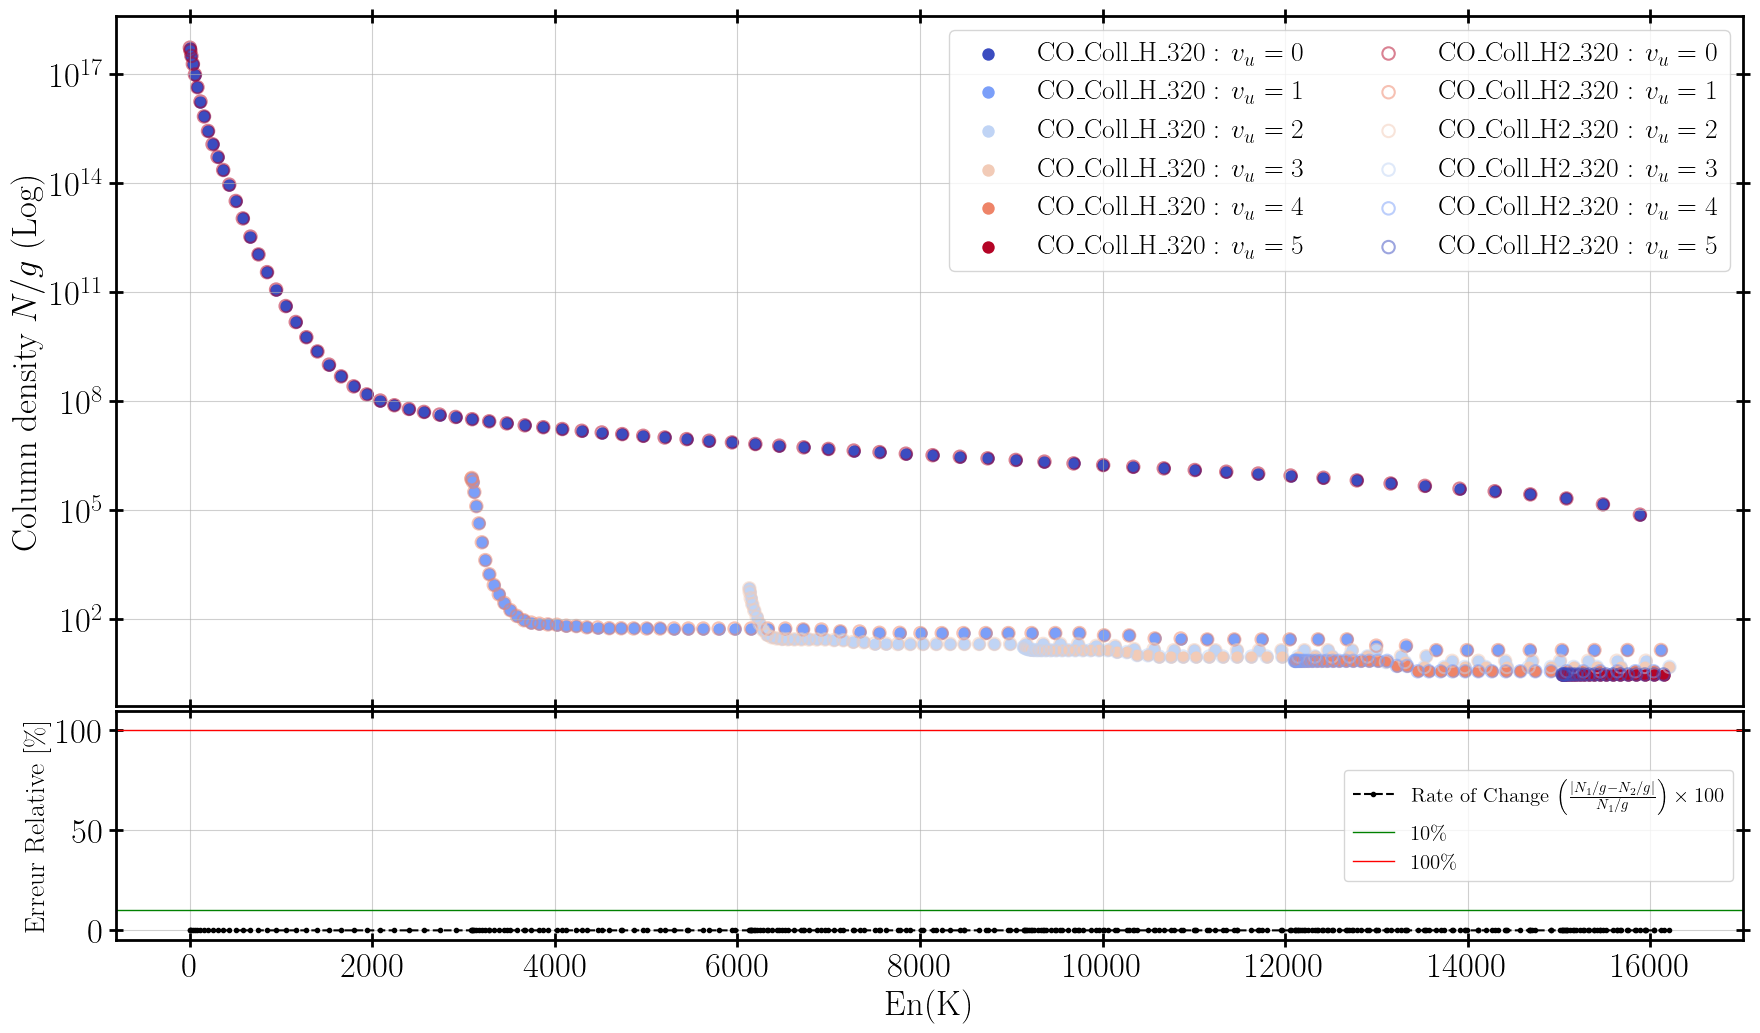

In [33]:
v_levels_to_plot = [0,1,2,3,4,5]
label_1 = "Coll_H_320"
label_2 = "Coll_H2_320"

Model1 = Model[label_1]
Model2 = Model[label_2]

plot_comparative_excitation(data1=Model1,data2=Model2,
    label1=label_1,label2=label_2,
    v_levels_to_plot=v_levels_to_plot,
    x_col='En(K)', y_col='Norm',molecule_name='CO')

#### Observations : 


### e. Considering UV cascade A->X

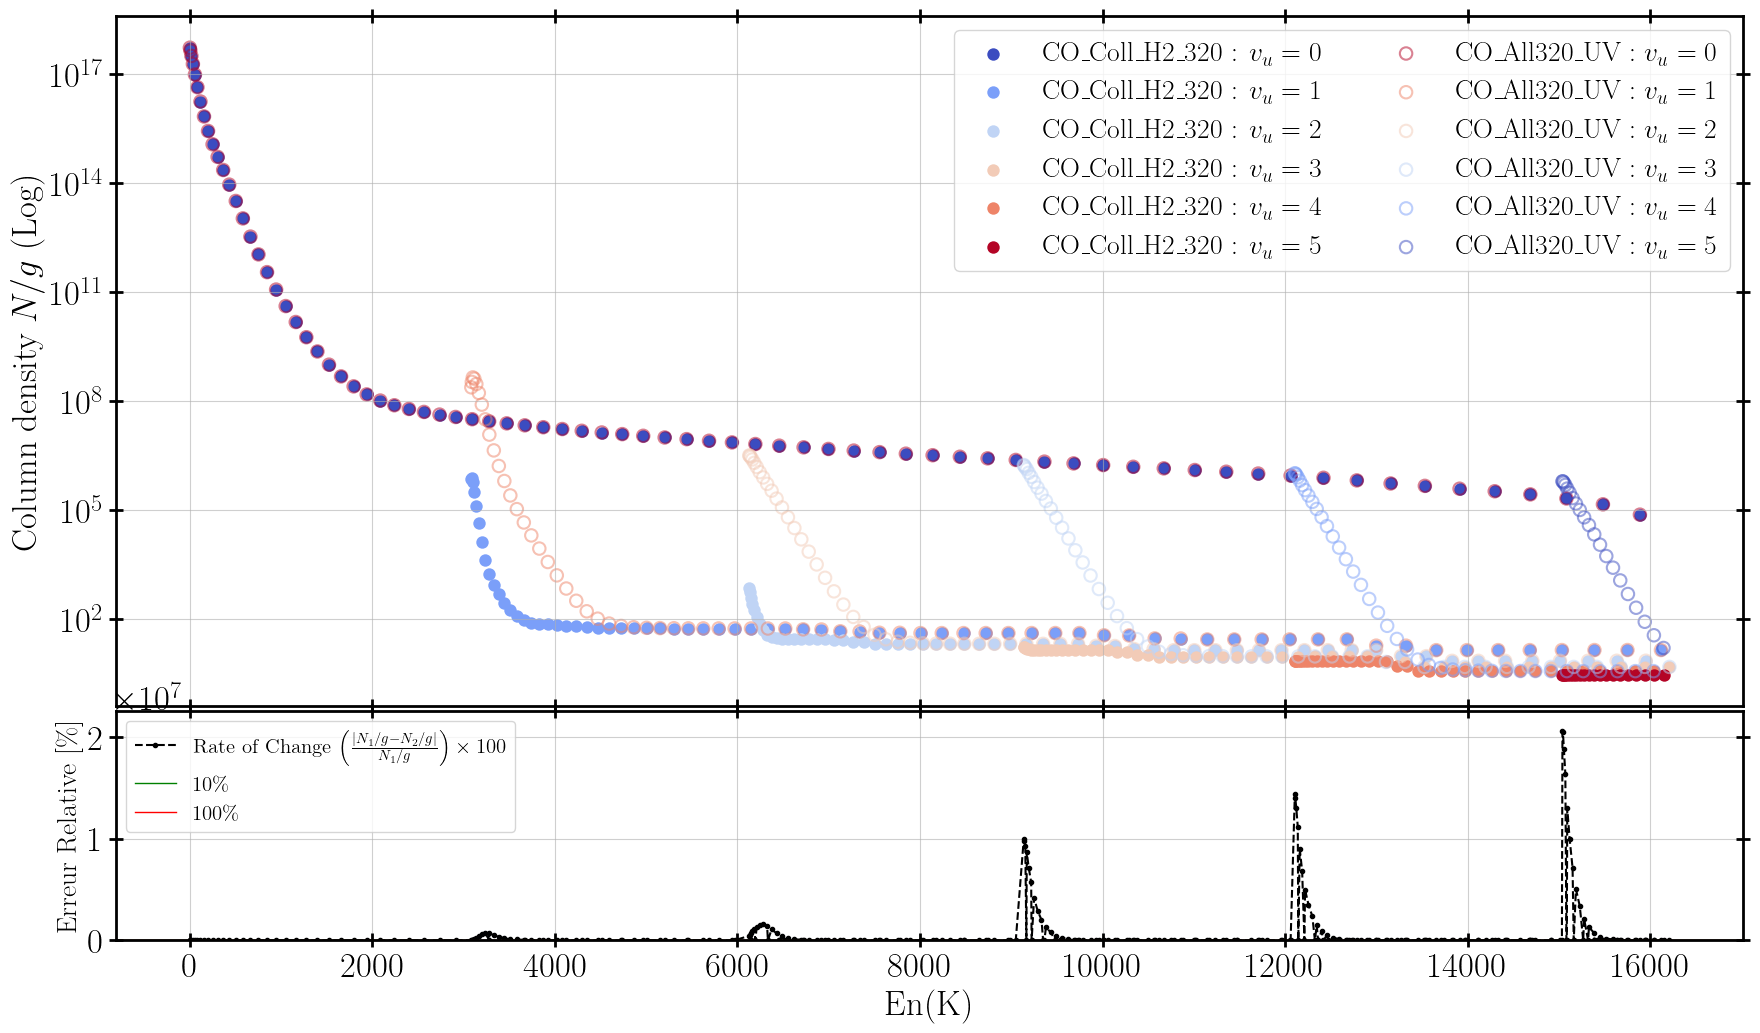

In [34]:
v_levels_to_plot = [0,1,2,3,4,5]
label_1 = "Coll_H2_320"
label_2 = "All320_UV"

Model1 = Model[label_1]
Model2 = Model[label_2]

plot_comparative_excitation(data1=Model1,data2=Model2,
    label1=label_1,label2=label_2,
    v_levels_to_plot=v_levels_to_plot,
    x_col='En(K)', y_col='Norm',molecule_name='CO')

#### Observation: 
Activating the UV transfer from A-> X creates a drastic change at low J for every v>0. 
- v=0 remains unaffected by this UV cascade
- v>0 at low J have a drastic difference with multiples orders of magnitude difference
Please note that the A->X radiative transfer doesn't take into account the broadening of the lines (self shielding) and is not solved exactly like the other processes

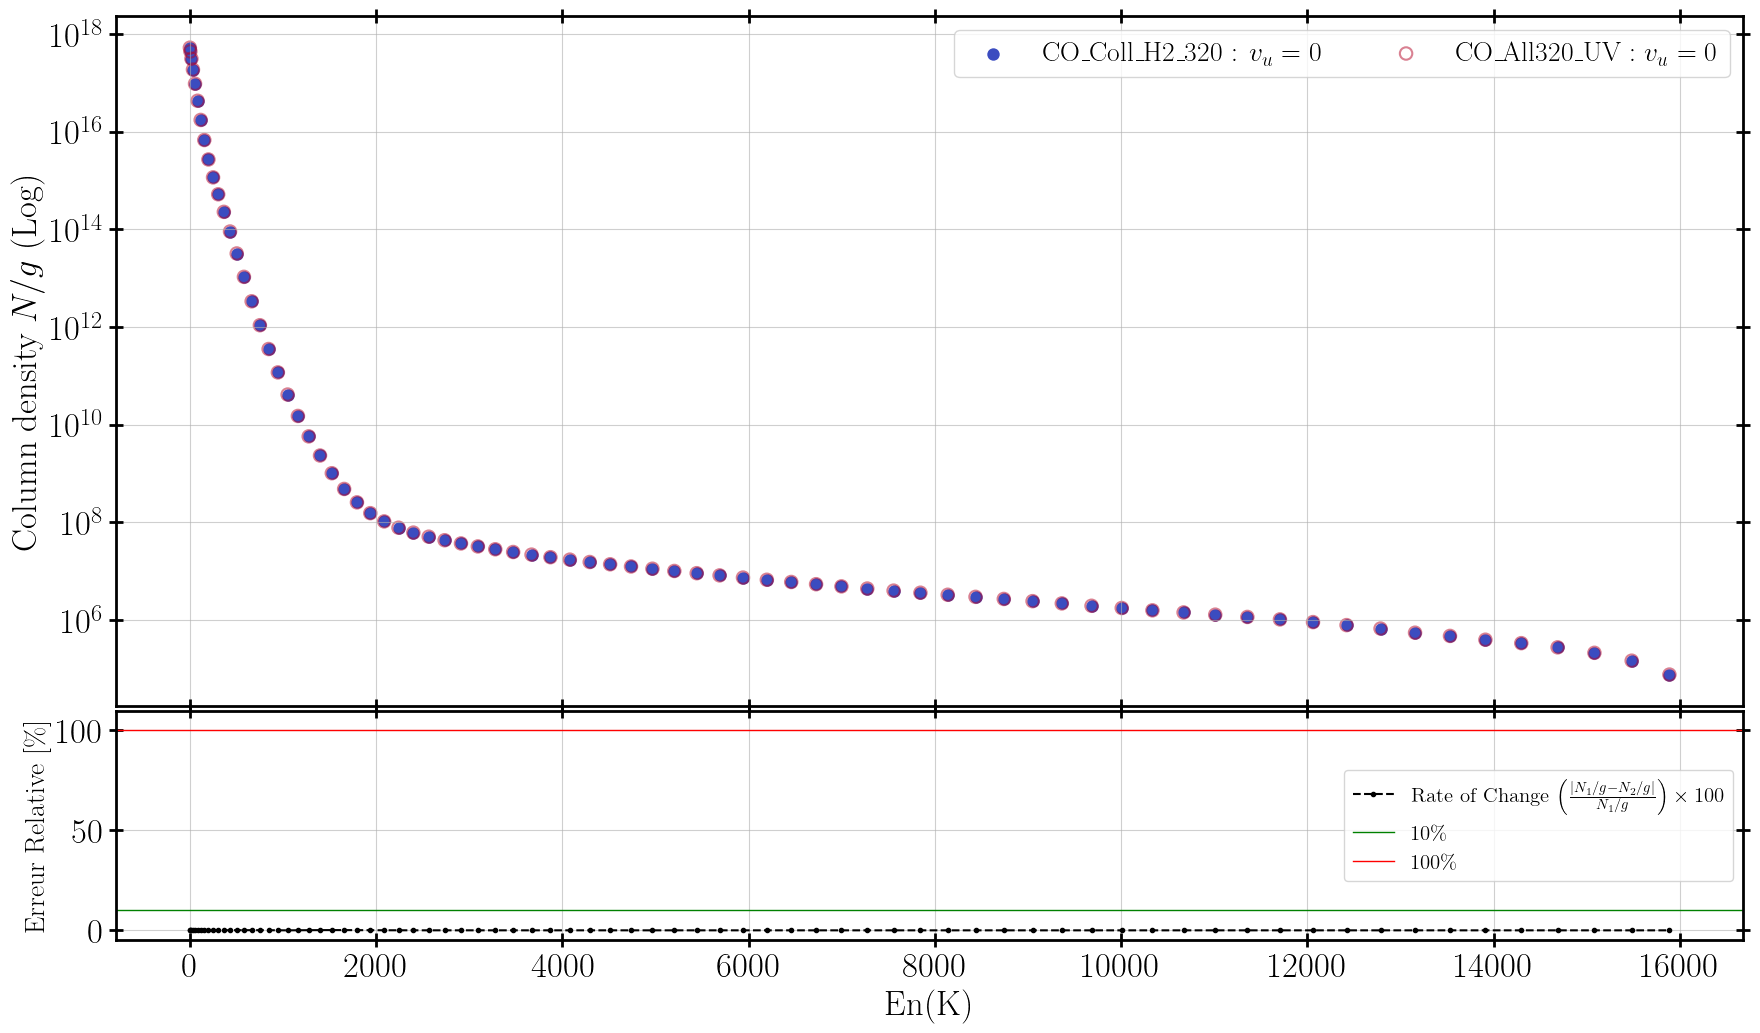

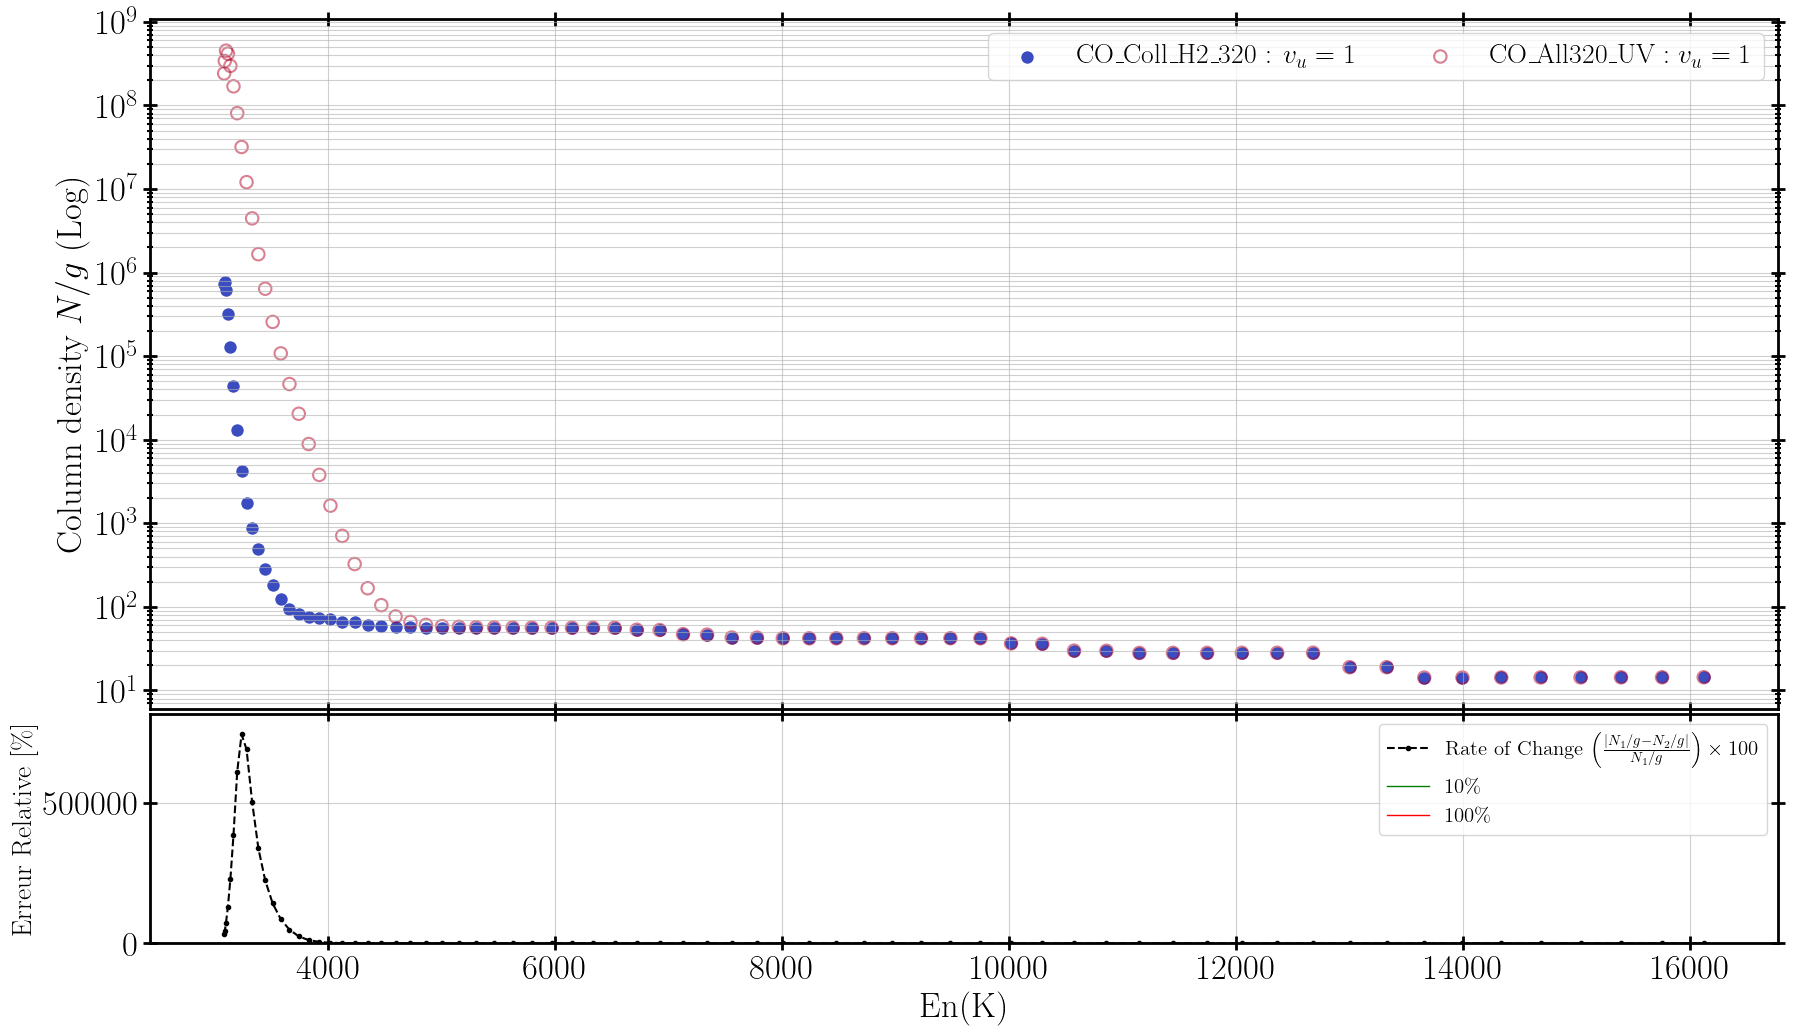

In [35]:
#------------------------------
v_levels_to_plot = [0]
label_1 = "Coll_H2_320"
label_2 = "All320_UV"

Model1 = Model[label_1]
Model2 = Model[label_2]

plot_comparative_excitation(data1=Model1,data2=Model2,
    label1=label_1,label2=label_2,
    v_levels_to_plot=v_levels_to_plot,
    x_col='En(K)', y_col='Norm',molecule_name='CO')

#------------------------------
v_levels_to_plot = [1]
label_1 = "Coll_H2_320"
label_2 = "All320_UV"

Model1 = Model[label_1]
Model2 = Model[label_2]

plot_comparative_excitation(data1=Model1,data2=Model2,
    label1=label_1,label2=label_2,
    v_levels_to_plot=v_levels_to_plot,
    x_col='En(K)', y_col='Norm',molecule_name='CO')

### f. Considering "Exact" transfer for levels > A
En modifiant le flag l_trc_co #Upper CO level included in full transfer dans PXDR_06 de 0 à 1 

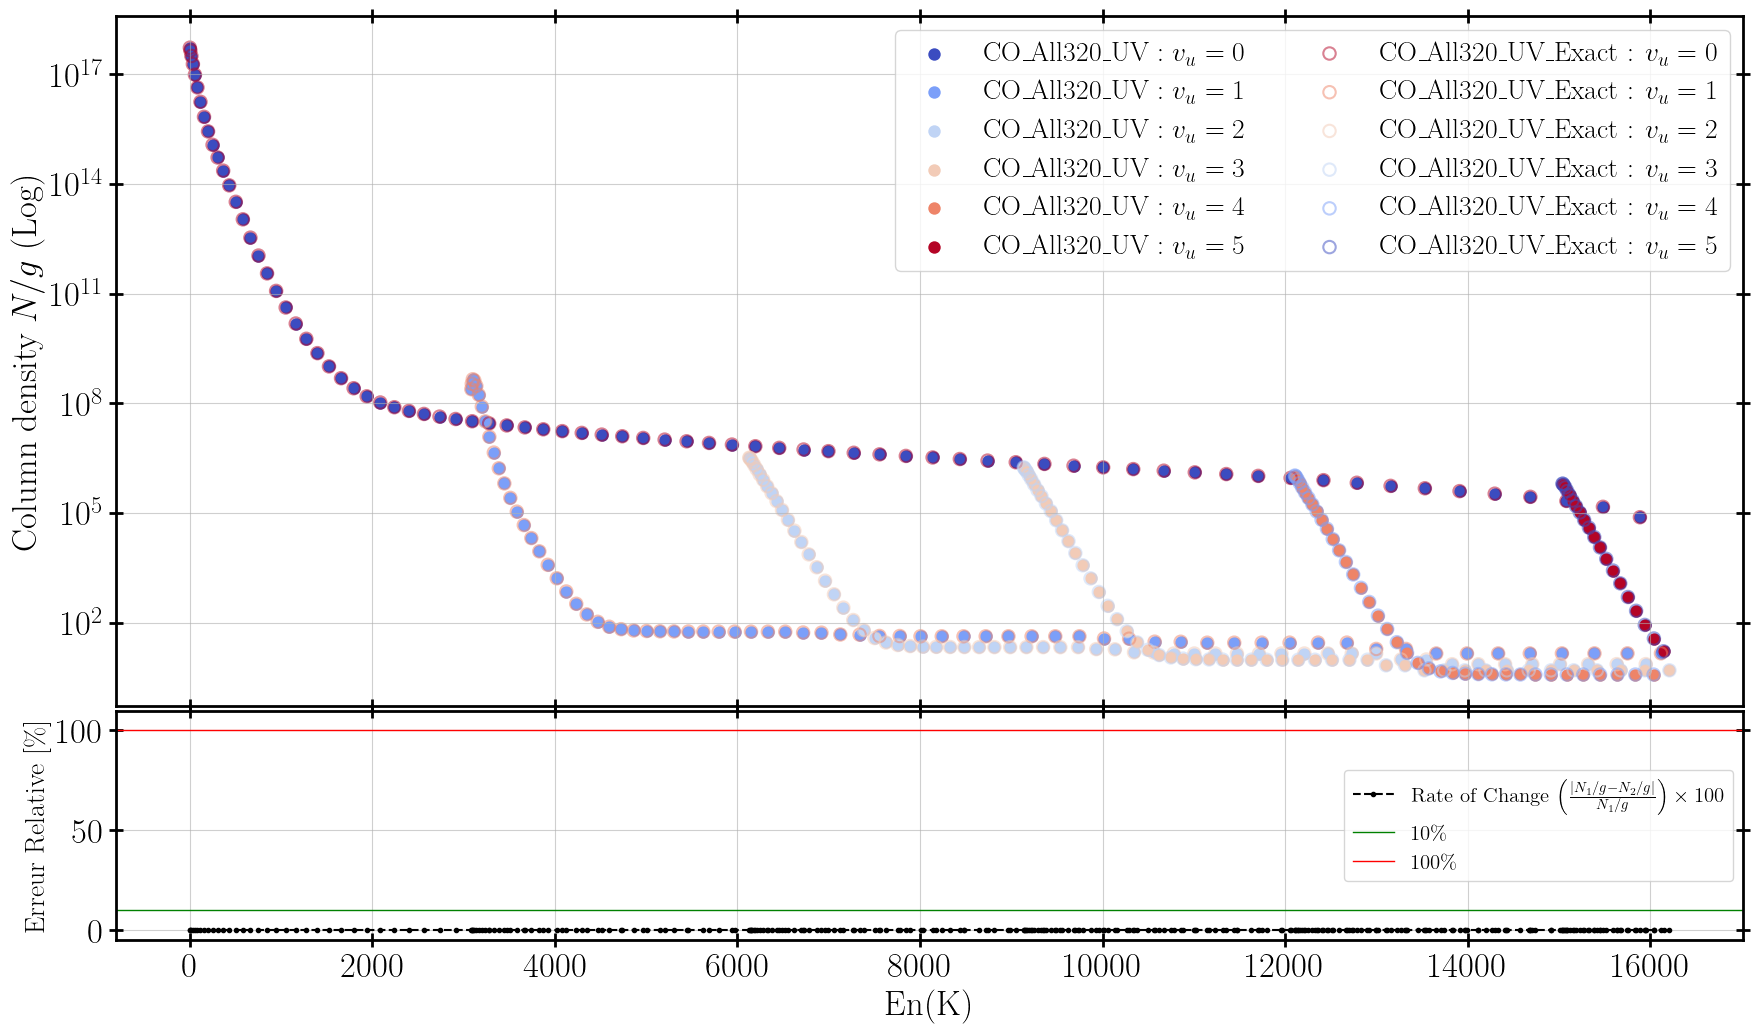

In [38]:
#------------------------------
v_levels_to_plot = [0,1,2,3,4,5]
label_1 = "All320_UV"
label_2 = "All320_UV_Exact"

Model1 = Model[label_1]
Model2 = Model[label_2]

plot_comparative_excitation(data1=Model1,data2=Model2,
    label1=label_1,label2=label_2,
    v_levels_to_plot=v_levels_to_plot,
    x_col='En(K)', y_col='Norm',molecule_name='CO')

#### Observations : 
Aucun changement notable dans cette partie


# In progress

In [53]:
from typing import Optional, List, Dict, Union

def dfs_to_excitation_plotly(
    dfs: Dict[str, pd.DataFrame],  # <-- Changement majeur : Dictionnaire de DataFrames
    x_col: str = 'En(K)',
    y_col: str = 'Norm',
    color_col: str = 'v',
    molecule_name: str = 'CO',
    v_levels_to_plot: Optional[List[int]] = None,
    cmap: str = "viridis",
    log_y: bool = True
    ) -> go.Figure:
    
    # --- 1. Préparation et Concaténation des données ---
    required_cols = [x_col, y_col, color_col, 'n', 'v', 'J']
    df_list = []

    # Création d'une colonne 'Source' pour identifier chaque DataFrame
    for name, df in dfs.items():
        if not all(col in df.columns for col in required_cols):
            missing_cols = [col for col in required_cols if col not in df.columns]
            raise ValueError(f"Le DataFrame '{name}' ne contient pas les colonnes nécessaires : {missing_cols}")
        
        df_temp = df.copy()
        # Ajout d'une colonne 'Source' pour différencier les DataFrames sur le graphique
        df_temp['Source'] = name 
        df_list.append(df_temp)

    if not df_list:
        return px.scatter(title="Figure Vide", labels={}) # Retourne une figure vide si la liste est vide

    # Concaténation de tous les DataFrames en un seul pour Plotly Express
    df_combined = pd.concat(df_list, ignore_index=True)

    # --- 2. FILTRAGE DES NIVEAUX VIBRATIONNELS ---
    df_plot = df_combined.copy()
    if v_levels_to_plot is not None:
        # Applique le filtre sur la colonne de couleur/niveau 'v'
        df_plot = df_plot[df_plot[color_col].isin(v_levels_to_plot)].copy() 
        if df_plot.empty:
             print(f"Avertissement : Aucun point trouvé pour les niveaux spécifiés : {v_levels_to_plot}.")
             return px.scatter(title="Figure Vide", labels={})

    # --- 3. Définition des données pour customdata ---
    # Ordre : [n, v, J, Source]
    custom_data_cols = ['n', 'v', 'J', 'Source'] 

    # --- 4. Création du diagramme Plotly Express ---
    fig = px.scatter(
        df_plot, # Utilise le DataFrame COMBINÉ et FILTRÉ
        x=x_col,
        y=y_col,
        color=color_col,  # Garde la couleur pour le niveau vibrationnel
        symbol='Source',  # <--- Ajout : Utilise 'Source' (le nom du DF) pour la forme du marqueur
        log_y=log_y,
        color_continuous_scale=cmap,
        labels={
            x_col: r'Upper level energy E<sub>u</sub> [K]',
            y_col: r'Normalised column density N<sub>u</sub>/g<sub>u</sub> [cm<sup>-2</sup>]',
            color_col: 'Vibrational level v<sub>u</sub>',
            'Source': 'Data Source' # Étiquette pour la légende du symbole
        },
        title=f"Diagramme de Population Rotationnel pour {molecule_name} (Comparaison)",
    )
    
    # --- 5. Configuration des étiquettes (hovertemplate) ---
    
    # Définition du modèle d'étiquette personnalisé
    # Note : 'Source' est maintenant customdata[3]
    custom_template = (
        f"Source=%{{customdata[3]}}<br>" # Source (index 3)
        f"Upper level energy E<sub>u</sub> [K]=%{{x:.3f}}<br>"
        f"Normalised column density N<sub>u</sub>/g<sub>u</sub> [cm²]=%{{y:.5f}}<br>"
        f"Vibrational level v<sub>u</sub>=%{{customdata[1]}}<br>" # v (index 1)
        f"n=%{{customdata[0]}}<br>" # n (index 0)
        f"J=%{{customdata[2]}}<extra></extra>" # J (index 2)
    )
    
    # Mise à jour des traces
    fig.update_traces(
        marker=dict(size=10, opacity=0.8),
        # On passe customdata AVEC les données FILTRÉES, incluant 'Source'
        customdata=df_plot[custom_data_cols], 
        hovertemplate=custom_template
    )
    
    # --- 6. Mises à jour esthétiques finales ---
    fig.update_layout(
        xaxis_title=fig.layout.xaxis.title.text,
        yaxis_title=fig.layout.yaxis.title.text,
        legend_title_text='Data Source', # Titre de la légende pour le symbole
        template="plotly_white", # Un thème propre
    )
    
    # Ajuster la barre de couleur (Colorbar) pour qu'elle corresponde au niveau 'v'
    fig.update_layout(
        coloraxis_colorbar=dict(
            title='Vibrational level v<sub>u</sub>',
            # Personnalisation pour mieux gérer les échelles continues si 'v' est discret
        )
    )

    return fig

In [56]:
#Selection of one or multiple levels to plot
v_levels = [1]
cles_a_extraire = ['Base64', 'All64']

# Création du sous-dictionnaire
sous_dico = {
    cle: Model[cle] 
    for cle in cles_a_extraire 
    if cle in Model # Ajout d'une vérification pour éviter une KeyError
    }

fig = dfs_to_excitation_plotly(
    sous_dico,
    x_col='En(K)',
    y_col='Norm',
    color_col='v',
    molecule_name=f"{mol}_{ModelName}",
    v_levels_to_plot=v_levels,
    cmap="mint")
fig.show() 
#You have the detail of every level considered by passing the mouse on it 